In [1]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118
Is CUDA enabled? True


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2060


In [54]:
import torch, os
import pandas as pd
from transformers import pipeline, XLNetTokenizer, XLNetForSequenceClassification, XLNetTokenizerFast, XLNetModel
from torch.utils.data import Dataset

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
ROOT_DIR = '../'

df_org= pd.read_csv(ROOT_DIR + "fifa_world_cup_2022_tweets.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
16498,16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral
15542,15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative
11893,11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral
5496,5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral
4645,4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral


In [6]:
df_org.drop('Unnamed: 0',axis=1, inplace=True)
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral
...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive


In [7]:
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# download(['punkt','vader_lexicon'])

Sentiment
negative    5784
neutral     8251
positive    8489
Name: count, dtype: int64


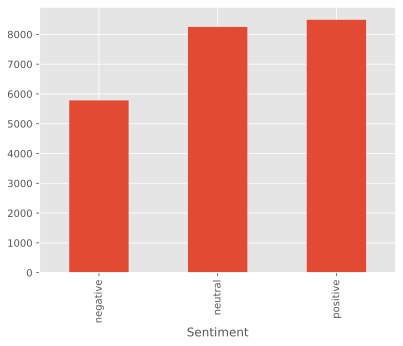

In [8]:
print(df_org['Sentiment'].value_counts().sort_index())
df_org['Sentiment'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [9]:
# using regex to clean the tweets, removing usernames, urls, stopwords, etc.
def preprocess(text):
    text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
    text = re.sub(r'\bhttps?://\S+\b', 'http', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

In [21]:
# import nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
df_org['preprocessed_tweet'] = df_org['Tweet'].apply(preprocess)

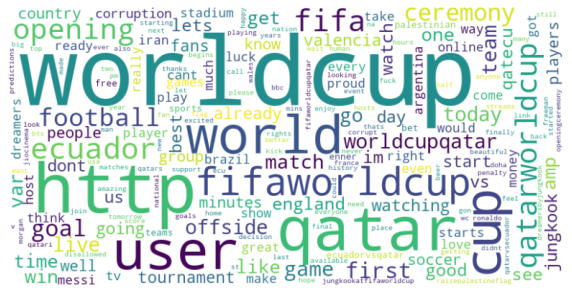

In [11]:
# Calculate word frequencies
word_freq = df_org['preprocessed_tweet'].str.split().explode().value_counts().reset_index()
word_freq.columns = ['Word', 'Frequency']
word_freq['Frequency'] = word_freq['Frequency'].astype(int)  # Convert frequency column to integers

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.set_index('Word')['Frequency'].to_dict())

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
labels = df_org['Sentiment'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['neutral', 'negative', 'positive']

In [13]:
for key, value in enumerate(labels):
    print(value)

neutral
negative
positive


In [14]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [15]:
label2id

{'neutral': 0, 'negative': 1, 'positive': 2}

In [16]:
id2label

{0: 'neutral', 1: 'negative', 2: 'positive'}

In [17]:
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral,ecuador players losing qatar tonight fifaworld...
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative,morgan freeman old damn cant believe worldcup
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral,guess worldcup opener ahead governing bodies f...
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral,going hear user pundits talk usa regarding war...
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral,hattrick already qatecu worldcup
...,...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative,never felt unenthusiastic major sporting event...
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive,getting started first step start investment in...
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral,monday bargain bin worldcup begun lets see int...
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive,tomorrow usa plays wales world cup well openin...


In [18]:
df_org["labels"]=df_org['Sentiment'].map(lambda x: label2id[x.strip()])

In [19]:
df_org

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,labels
16498,2022-11-20 14:18:51+00:00,0,Twitter for Android,Ecuador players after losing 1-0 against Qatar...,neutral,ecuador players losing qatar tonight fifaworld...,0
15542,2022-11-20 14:53:29+00:00,0,Twitter for iPhone,Morgan Freeman too old damn can’t believe #Wor...,negative,morgan freeman old damn cant believe worldcup,1
11893,2022-11-20 15:53:34+00:00,0,Twitter Web App,"So, I guess we have a #WorldCup2022 opener ahe...",neutral,guess worldcup opener ahead governing bodies f...,0
5496,2022-11-20 16:27:10+00:00,0,Twitter for iPhone,So are we going to hear @GaryLineker and other...,neutral,going hear user pundits talk usa regarding war...,0
4645,2022-11-20 16:36:42+00:00,0,Twitter for Android,Should have had a hattrick already. #QATECU #W...,neutral,hattrick already qatecu worldcup,0
...,...,...,...,...,...,...,...
11964,2022-11-20 15:52:30+00:00,1,Twitter for iPhone,Never felt so unenthusiastic about a major spo...,negative,never felt unenthusiastic major sporting event...,1
21575,2022-11-20 04:57:59+00:00,165,Twitter Web App,Getting started is the first step. Start your ...,positive,getting started first step start investment in...,2
5390,2022-11-20 16:29:05+00:00,6,Twitter Web App,🚨MONDAY ON THE BARGAIN BIN!🚨\n\nThe #WorldCup2...,neutral,monday bargain bin worldcup begun lets see int...,0
860,2022-11-20 21:00:35+00:00,1,Twitter Web App,Tomorrow USA plays Wales in the World Cup! We’...,positive,tomorrow usa plays wales world cup well openin...,2


<Axes: ylabel='count'>

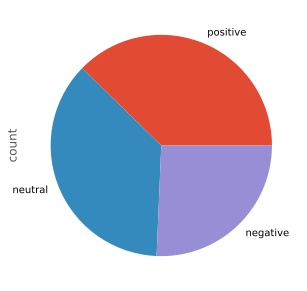

In [20]:
df_org['Sentiment'].value_counts().plot(kind='pie', figsize=(5,5))

In [59]:
tokenizer = XLNetTokenizer.from_pretrained("sshleifer/tiny-xlnet-base-cased", max_length=512)

In [75]:
model = XLNetForSequenceClassification.from_pretrained("sshleifer/tiny-xlnet-base-cased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at sshleifer/tiny-xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 4)
    (layer): ModuleList(
      (0-1): 2 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((4,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((4,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=4, out_features=2, bias=True)
          (layer_2): Linear(in_features=2, out_features=4, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=4, out_features=4, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last_dropout): Dropout(p=0

In [76]:
# Splitting df_org

SIZE= df_org.shape[0]

train_texts= list(df_org.preprocessed_tweet[:SIZE//2])

val_texts=   list(df_org.preprocessed_tweet[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.preprocessed_tweet[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [77]:
len(train_texts)

11262

In [78]:
len(train_texts), len(val_texts), len(test_texts)

(11262, 5631, 5631)

In [79]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [80]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [81]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [82]:
# Training with Trainer Class
from transformers import TrainingArguments, Trainer

In [83]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [84]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./fifa22-tweet-xlnet-results',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 2.0
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./fifa22-tweet-xlnet-logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [85]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [86]:
torch.cuda.empty_cache()

In [87]:
trainer.train()

  0%|          | 10/2816 [00:00<01:46, 26.32it/s]

{'loss': 1.0986, 'learning_rate': 5e-06, 'epoch': 0.01}



























                                                 

  0%|          | 10/2816 [00:02<01:46, 26.32it/s] 

  1%|          | 18/2816 [00:02<07:16,  6.41it/s]
                                                 

{'eval_loss': 1.098737359046936, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.466, 'eval_samples_per_second': 2283.454, 'eval_steps_per_second': 142.741, 'epoch': 0.01}
{'loss': 1.0986, 'learning_rate': 1e-05, 'epoch': 0.01}


  1%|          | 20/2816 [00:03<07:16,  6.41it/s]
























                                                 

  1%|          | 20/2816 [00:05<07:16,  6.41it/s] 

  1%|          | 28/2816 [00:05<08:57,  5.19it/s]


{'eval_loss': 1.0987355709075928, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.51, 'eval_samples_per_second': 2243.427, 'eval_steps_per_second': 140.239, 'epoch': 0.01}


  1%|          | 30/2816 [00:05<08:56,  5.19it/s]

{'loss': 1.0986, 'learning_rate': 1.5e-05, 'epoch': 0.02}




























                                                 

  1%|          | 30/2816 [00:08<08:56,  5.19it/s] 

  1%|▏         | 38/2816 [00:08<09:53,  4.68it/s]


{'eval_loss': 1.0987293720245361, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.677, 'eval_samples_per_second': 2103.476, 'eval_steps_per_second': 131.491, 'epoch': 0.02}


  1%|▏         | 40/2816 [00:08<09:52,  4.68it/s]

{'loss': 1.0986, 'learning_rate': 2e-05, 'epoch': 0.03}



























                                                 

  1%|▏         | 40/2816 [00:11<09:52,  4.68it/s] 

  2%|▏         | 49/2816 [00:11<09:26,  4.88it/s]
                                                 
  0%|          | 0/2816 [01:15<?, ?it/s]

{'eval_loss': 1.0987194776535034, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.521, 'eval_samples_per_second': 2233.638, 'eval_steps_per_second': 139.627, 'epoch': 0.03}
{'loss': 1.0987, 'learning_rate': 2.5e-05, 'epoch': 0.04}


  2%|▏         | 50/2816 [00:11<09:26,  4.88it/s]























                                                 

  2%|▏         | 50/2816 [00:13<09:26,  4.88it/s] 

  2%|▏         | 60/2816 [00:13<08:57,  5.13it/s]

{'eval_loss': 1.0987095832824707, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.373, 'eval_samples_per_second': 2372.945, 'eval_steps_per_second': 148.335, 'epoch': 0.04}
{'loss': 1.0987, 'learning_rate': 3e-05, 'epoch': 0.04}


























                                                 

  2%|▏         | 60/2816 [00:16<08:57,  5.13it/s] 

  2%|▏         | 70/2816 [00:16<13:28,  3.40it/s]

{'eval_loss': 1.0986953973770142, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.386, 'eval_samples_per_second': 2360.016, 'eval_steps_per_second': 147.527, 'epoch': 0.04}
{'loss': 1.0986, 'learning_rate': 3.5e-05, 'epoch': 0.05}

























                                                 

  2%|▏         | 70/2816 [00:18<13:28,  3.40it/s] 

  3%|▎         | 80/2816 [00:18<09:35,  4.75it/s]

{'eval_loss': 1.0986615419387817, 'eval_Accuracy': 0.25306339904102293, 'eval_F1': 0.13463718820861678, 'eval_Precision': 0.08435446634700765, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.305, 'eval_samples_per_second': 2442.951, 'eval_steps_per_second': 152.712, 'epoch': 0.05}
{'loss': 1.0986, 'learning_rate': 4e-05, 'epoch': 0.06}


























                                                 

  3%|▎         | 80/2816 [00:21<09:35,  4.75it/s] 

  3%|▎         | 90/2816 [00:21<08:58,  5.06it/s]

{'eval_loss': 1.0986253023147583, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.356, 'eval_samples_per_second': 2390.067, 'eval_steps_per_second': 149.406, 'epoch': 0.06}
{'loss': 1.0985, 'learning_rate': 4.5e-05, 'epoch': 0.06}


























                                                 

  3%|▎         | 90/2816 [00:23<08:58,  5.06it/s] 

  4%|▎         | 100/2816 [00:23<08:38,  5.24it/s]

{'eval_loss': 1.0985960960388184, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.358, 'eval_samples_per_second': 2388.037, 'eval_steps_per_second': 149.279, 'epoch': 0.06}
{'loss': 1.0986, 'learning_rate': 5e-05, 'epoch': 0.07}

























                                                  

  4%|▎         | 100/2816 [00:26<08:38,  5.24it/s]

  4%|▍         | 110/2816 [00:26<12:51,  3.51it/s]

{'eval_loss': 1.0985690355300903, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.331, 'eval_samples_per_second': 2415.702, 'eval_steps_per_second': 151.008, 'epoch': 0.07}
{'loss': 1.0984, 'learning_rate': 4.9815905743740795e-05, 'epoch': 0.08}


























                                                  

  4%|▍         | 110/2816 [00:28<12:51,  3.51it/s]

  4%|▍         | 120/2816 [00:28<09:21,  4.80it/s]

{'eval_loss': 1.0985244512557983, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.319, 'eval_samples_per_second': 2428.203, 'eval_steps_per_second': 151.79, 'epoch': 0.08}
{'loss': 1.0987, 'learning_rate': 4.9631811487481595e-05, 'epoch': 0.09}

























                                                  

  4%|▍         | 120/2816 [00:31<09:21,  4.80it/s]

  5%|▍         | 130/2816 [00:31<08:43,  5.13it/s]

{'eval_loss': 1.0984845161437988, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.305, 'eval_samples_per_second': 2442.95, 'eval_steps_per_second': 152.711, 'epoch': 0.09}
{'loss': 1.0984, 'learning_rate': 4.944771723122239e-05, 'epoch': 0.09}

























                                                  

  5%|▍         | 130/2816 [00:33<08:43,  5.13it/s]

  5%|▍         | 140/2816 [00:33<08:23,  5.32it/s]

{'eval_loss': 1.0984470844268799, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.31, 'eval_samples_per_second': 2437.664, 'eval_steps_per_second': 152.381, 'epoch': 0.09}
{'loss': 1.0983, 'learning_rate': 4.926362297496319e-05, 'epoch': 0.1}

























                                                  

  5%|▍         | 140/2816 [00:36<08:23,  5.32it/s]

  5%|▌         | 150/2816 [00:36<12:24,  3.58it/s]

{'eval_loss': 1.0984083414077759, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.293, 'eval_samples_per_second': 2455.735, 'eval_steps_per_second': 153.511, 'epoch': 0.1}
{'loss': 1.0982, 'learning_rate': 4.907952871870398e-05, 'epoch': 0.11}


























                                                  

  5%|▌         | 150/2816 [00:38<12:24,  3.58it/s]

  6%|▌         | 160/2816 [00:38<09:08,  4.84it/s]

{'eval_loss': 1.0983593463897705, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.333, 'eval_samples_per_second': 2413.628, 'eval_steps_per_second': 150.879, 'epoch': 0.11}
{'loss': 1.0983, 'learning_rate': 4.889543446244477e-05, 'epoch': 0.11}

























                                                  

  6%|▌         | 160/2816 [00:41<09:08,  4.84it/s]

  6%|▌         | 170/2816 [00:41<08:32,  5.16it/s]

{'eval_loss': 1.0983154773712158, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.304, 'eval_samples_per_second': 2444.012, 'eval_steps_per_second': 152.778, 'epoch': 0.11}
{'loss': 1.0984, 'learning_rate': 4.871134020618557e-05, 'epoch': 0.12}


























                                                  

  6%|▌         | 170/2816 [00:43<08:32,  5.16it/s]

  6%|▋         | 180/2816 [00:43<08:23,  5.24it/s]

{'eval_loss': 1.0982730388641357, 'eval_Accuracy': 0.36725270822234063, 'eval_F1': 0.17907087500541197, 'eval_Precision': 0.12241756940744687, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.396, 'eval_samples_per_second': 2350.167, 'eval_steps_per_second': 146.912, 'epoch': 0.12}
{'loss': 1.0983, 'learning_rate': 4.8527245949926364e-05, 'epoch': 0.13}


























                                                  

  6%|▋         | 180/2816 [00:46<08:23,  5.24it/s]

  7%|▋         | 190/2816 [00:46<12:35,  3.48it/s]

{'eval_loss': 1.0982353687286377, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.399, 'eval_samples_per_second': 2347.228, 'eval_steps_per_second': 146.728, 'epoch': 0.13}
{'loss': 1.098, 'learning_rate': 4.834315169366716e-05, 'epoch': 0.13}


























                                                  

  7%|▋         | 190/2816 [00:48<12:35,  3.48it/s]

  7%|▋         | 200/2816 [00:48<09:09,  4.76it/s]

{'eval_loss': 1.0981944799423218, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.325, 'eval_samples_per_second': 2421.936, 'eval_steps_per_second': 151.398, 'epoch': 0.13}
{'loss': 1.0981, 'learning_rate': 4.8159057437407956e-05, 'epoch': 0.14}

























                                                  

  7%|▋         | 200/2816 [00:51<09:09,  4.76it/s]

  7%|▋         | 210/2816 [00:51<08:29,  5.11it/s]

{'eval_loss': 1.0981431007385254, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.298, 'eval_samples_per_second': 2450.392, 'eval_steps_per_second': 153.177, 'epoch': 0.14}
{'loss': 1.0981, 'learning_rate': 4.797496318114875e-05, 'epoch': 0.15}


























                                                  

  7%|▋         | 210/2816 [00:53<08:29,  5.11it/s]

  8%|▊         | 220/2816 [00:53<08:10,  5.29it/s]

{'eval_loss': 1.0981035232543945, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.323, 'eval_samples_per_second': 2424.021, 'eval_steps_per_second': 151.528, 'epoch': 0.15}
{'loss': 1.0986, 'learning_rate': 4.779086892488955e-05, 'epoch': 0.16}

























                                                  

  8%|▊         | 220/2816 [00:56<08:10,  5.29it/s]

  8%|▊         | 230/2816 [00:56<12:06,  3.56it/s]

{'eval_loss': 1.0980933904647827, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.305, 'eval_samples_per_second': 2442.951, 'eval_steps_per_second': 152.712, 'epoch': 0.16}
{'loss': 1.099, 'learning_rate': 4.760677466863034e-05, 'epoch': 0.16}

























                                                  

  8%|▊         | 230/2816 [00:58<12:06,  3.56it/s]

  9%|▊         | 240/2816 [00:58<08:50,  4.85it/s]

{'eval_loss': 1.098088264465332, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.304, 'eval_samples_per_second': 2444.011, 'eval_steps_per_second': 152.778, 'epoch': 0.16}
{'loss': 1.0978, 'learning_rate': 4.7422680412371134e-05, 'epoch': 0.17}


























                                                  

  9%|▊         | 240/2816 [01:01<08:50,  4.85it/s]

  9%|▉         | 250/2816 [01:01<08:19,  5.14it/s]

{'eval_loss': 1.0980706214904785, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.329, 'eval_samples_per_second': 2417.775, 'eval_steps_per_second': 151.138, 'epoch': 0.17}
{'loss': 1.0978, 'learning_rate': 4.723858615611193e-05, 'epoch': 0.18}

























                                                  

  9%|▉         | 250/2816 [01:03<08:19,  5.14it/s]

  9%|▉         | 260/2816 [01:03<08:00,  5.32it/s]

{'eval_loss': 1.0980346202850342, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.308, 'eval_samples_per_second': 2439.775, 'eval_steps_per_second': 152.513, 'epoch': 0.18}
{'loss': 1.0977, 'learning_rate': 4.7054491899852726e-05, 'epoch': 0.18}


























                                                  

  9%|▉         | 260/2816 [01:06<08:00,  5.32it/s]

 10%|▉         | 270/2816 [01:06<12:09,  3.49it/s]

{'eval_loss': 1.0979909896850586, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.403, 'eval_samples_per_second': 2343.322, 'eval_steps_per_second': 146.484, 'epoch': 0.18}
{'loss': 1.0973, 'learning_rate': 4.687039764359352e-05, 'epoch': 0.19}


























                                                  

 10%|▉         | 270/2816 [01:08<12:09,  3.49it/s]

 10%|▉         | 280/2816 [01:08<08:51,  4.77it/s]

{'eval_loss': 1.097933053970337, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.331, 'eval_samples_per_second': 2415.7, 'eval_steps_per_second': 151.008, 'epoch': 0.19}
{'loss': 1.0982, 'learning_rate': 4.668630338733432e-05, 'epoch': 0.2}

























                                                  

 10%|▉         | 280/2816 [01:11<08:51,  4.77it/s]

 10%|█         | 290/2816 [01:11<08:14,  5.11it/s]

{'eval_loss': 1.0978893041610718, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.317, 'eval_samples_per_second': 2430.297, 'eval_steps_per_second': 151.921, 'epoch': 0.2}
{'loss': 1.0983, 'learning_rate': 4.650220913107511e-05, 'epoch': 0.21}


























                                                  

 10%|█         | 290/2816 [01:13<08:14,  5.11it/s]

 11%|█         | 300/2816 [01:13<07:56,  5.28it/s]

{'eval_loss': 1.097853422164917, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.334, 'eval_samples_per_second': 2412.597, 'eval_steps_per_second': 150.814, 'epoch': 0.21}
{'loss': 1.0985, 'learning_rate': 4.631811487481591e-05, 'epoch': 0.21}

























                                                  

 11%|█         | 300/2816 [01:16<07:56,  5.28it/s]

 11%|█         | 310/2816 [01:16<11:48,  3.54it/s]

{'eval_loss': 1.0978424549102783, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.33, 'eval_samples_per_second': 2416.74, 'eval_steps_per_second': 151.073, 'epoch': 0.21}
{'loss': 1.0968, 'learning_rate': 4.61340206185567e-05, 'epoch': 0.22}

























                                                  

 11%|█         | 310/2816 [01:18<11:48,  3.54it/s]

 11%|█▏        | 320/2816 [01:18<08:37,  4.82it/s]

{'eval_loss': 1.0977965593338013, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.314, 'eval_samples_per_second': 2433.45, 'eval_steps_per_second': 152.118, 'epoch': 0.22}
{'loss': 1.098, 'learning_rate': 4.5949926362297496e-05, 'epoch': 0.23}


























                                                  

 11%|█▏        | 320/2816 [01:21<08:37,  4.82it/s]

 12%|█▏        | 330/2816 [01:21<08:06,  5.11it/s]

{'eval_loss': 1.0977541208267212, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.335, 'eval_samples_per_second': 2411.563, 'eval_steps_per_second': 150.749, 'epoch': 0.23}
{'loss': 1.0977, 'learning_rate': 4.5765832106038295e-05, 'epoch': 0.23}


























                                                  

 12%|█▏        | 330/2816 [01:23<08:06,  5.11it/s]

 12%|█▏        | 340/2816 [01:23<07:47,  5.30it/s]

{'eval_loss': 1.0977219343185425, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.317, 'eval_samples_per_second': 2430.267, 'eval_steps_per_second': 151.919, 'epoch': 0.23}
{'loss': 1.0978, 'learning_rate': 4.558173784977909e-05, 'epoch': 0.24}

























                                                  

 12%|█▏        | 340/2816 [01:26<07:47,  5.30it/s]

 12%|█▏        | 350/2816 [01:26<11:33,  3.56it/s]

{'eval_loss': 1.0976821184158325, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.313, 'eval_samples_per_second': 2434.501, 'eval_steps_per_second': 152.183, 'epoch': 0.24}
{'loss': 1.0972, 'learning_rate': 4.539764359351989e-05, 'epoch': 0.25}


























                                                  

 12%|█▏        | 350/2816 [01:28<11:33,  3.56it/s]

 13%|█▎        | 360/2816 [01:28<08:27,  4.84it/s]

{'eval_loss': 1.097635269165039, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.316, 'eval_samples_per_second': 2431.348, 'eval_steps_per_second': 151.986, 'epoch': 0.25}
{'loss': 1.0976, 'learning_rate': 4.521354933726068e-05, 'epoch': 0.26}

























                                                  

 13%|█▎        | 360/2816 [01:31<08:27,  4.84it/s]

 13%|█▎        | 370/2816 [01:31<07:55,  5.14it/s]

{'eval_loss': 1.0975825786590576, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.321, 'eval_samples_per_second': 2426.11, 'eval_steps_per_second': 151.659, 'epoch': 0.26}
{'loss': 1.098, 'learning_rate': 4.502945508100147e-05, 'epoch': 0.26}


























                                                  

 13%|█▎        | 370/2816 [01:33<07:55,  5.14it/s]

 13%|█▎        | 380/2816 [01:33<07:40,  5.30it/s]

{'eval_loss': 1.0975559949874878, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.337, 'eval_samples_per_second': 2409.534, 'eval_steps_per_second': 150.623, 'epoch': 0.26}
{'loss': 1.0974, 'learning_rate': 4.484536082474227e-05, 'epoch': 0.27}

























                                                  

 13%|█▎        | 380/2816 [01:36<07:40,  5.30it/s]

 14%|█▍        | 390/2816 [01:36<11:21,  3.56it/s]

{'eval_loss': 1.0975221395492554, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.307, 'eval_samples_per_second': 2440.862, 'eval_steps_per_second': 152.581, 'epoch': 0.27}
{'loss': 1.0968, 'learning_rate': 4.4661266568483065e-05, 'epoch': 0.28}


























                                                  

 14%|█▍        | 390/2816 [01:38<11:21,  3.56it/s]

 14%|█▍        | 400/2816 [01:38<08:20,  4.83it/s]

{'eval_loss': 1.0974690914154053, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.33, 'eval_samples_per_second': 2416.739, 'eval_steps_per_second': 151.073, 'epoch': 0.28}
{'loss': 1.0975, 'learning_rate': 4.447717231222386e-05, 'epoch': 0.28}

























                                                  

 14%|█▍        | 400/2816 [01:41<08:20,  4.83it/s]

 15%|█▍        | 410/2816 [01:41<07:49,  5.13it/s]

{'eval_loss': 1.0974204540252686, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.319, 'eval_samples_per_second': 2428.234, 'eval_steps_per_second': 151.792, 'epoch': 0.28}
{'loss': 1.0968, 'learning_rate': 4.429307805596466e-05, 'epoch': 0.29}


























                                                  

 15%|█▍        | 410/2816 [01:43<07:49,  5.13it/s]

 15%|█▍        | 420/2816 [01:43<07:31,  5.30it/s]

{'eval_loss': 1.097375512123108, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.322, 'eval_samples_per_second': 2425.066, 'eval_steps_per_second': 151.594, 'epoch': 0.29}
{'loss': 1.0967, 'learning_rate': 4.410898379970545e-05, 'epoch': 0.3}

























                                                  

 15%|█▍        | 420/2816 [01:46<07:31,  5.30it/s]

 15%|█▌        | 430/2816 [01:46<11:10,  3.56it/s]

{'eval_loss': 1.097312569618225, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.313, 'eval_samples_per_second': 2434.501, 'eval_steps_per_second': 152.183, 'epoch': 0.3}
{'loss': 1.0976, 'learning_rate': 4.392488954344625e-05, 'epoch': 0.31}

























                                                  

 15%|█▌        | 430/2816 [01:48<11:10,  3.56it/s]

 16%|█▌        | 440/2816 [01:48<08:09,  4.85it/s]

{'eval_loss': 1.097267985343933, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.293, 'eval_samples_per_second': 2455.737, 'eval_steps_per_second': 153.511, 'epoch': 0.31}
{'loss': 1.0993, 'learning_rate': 4.374079528718704e-05, 'epoch': 0.31}


























                                                  

 16%|█▌        | 440/2816 [01:51<08:09,  4.85it/s]

 16%|█▌        | 450/2816 [01:51<07:42,  5.12it/s]

{'eval_loss': 1.097251057624817, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.352, 'eval_samples_per_second': 2394.122, 'eval_steps_per_second': 149.659, 'epoch': 0.31}
{'loss': 1.0989, 'learning_rate': 4.3556701030927835e-05, 'epoch': 0.32}


























                                                  

 16%|█▌        | 450/2816 [01:53<07:42,  5.12it/s]

 16%|█▋        | 460/2816 [01:53<07:29,  5.24it/s]

{'eval_loss': 1.0972516536712646, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.384, 'eval_samples_per_second': 2362.026, 'eval_steps_per_second': 147.653, 'epoch': 0.32}
{'loss': 1.0976, 'learning_rate': 4.3372606774668634e-05, 'epoch': 0.33}


























                                                  

 16%|█▋        | 460/2816 [01:56<07:29,  5.24it/s]

 17%|█▋        | 470/2816 [01:56<11:09,  3.50it/s]

{'eval_loss': 1.097245693206787, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.358, 'eval_samples_per_second': 2388.041, 'eval_steps_per_second': 149.279, 'epoch': 0.33}
{'loss': 1.0964, 'learning_rate': 4.318851251840943e-05, 'epoch': 0.33}

























                                                  

 17%|█▋        | 470/2816 [01:58<11:09,  3.50it/s]

 17%|█▋        | 477/2816 [01:58<08:34,  4.54it/s]


{'eval_loss': 1.0972020626068115, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.342, 'eval_samples_per_second': 2404.355, 'eval_steps_per_second': 150.299, 'epoch': 0.33}


 17%|█▋        | 480/2816 [01:58<08:34,  4.54it/s]

{'loss': 1.0986, 'learning_rate': 4.3004418262150226e-05, 'epoch': 0.34}



























                                                  

 17%|█▋        | 480/2816 [02:01<08:34,  4.54it/s]

 17%|█▋        | 487/2816 [02:01<08:35,  4.52it/s]


{'eval_loss': 1.097176432609558, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.532, 'eval_samples_per_second': 2223.936, 'eval_steps_per_second': 139.021, 'epoch': 0.34}


 17%|█▋        | 490/2816 [02:01<08:34,  4.52it/s]

{'loss': 1.0995, 'learning_rate': 4.282032400589102e-05, 'epoch': 0.35}


























                                                  

 17%|█▋        | 490/2816 [02:03<08:34,  4.52it/s]

 18%|█▊        | 497/2816 [02:04<08:21,  4.63it/s]


{'eval_loss': 1.0971819162368774, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.409, 'eval_samples_per_second': 2337.513, 'eval_steps_per_second': 146.12, 'epoch': 0.35}


 18%|█▊        | 500/2816 [02:04<08:20,  4.63it/s]

{'loss': 1.0968, 'learning_rate': 4.263622974963181e-05, 'epoch': 0.36}



























                                                  

 18%|█▊        | 500/2816 [02:06<08:20,  4.63it/s]

 18%|█▊        | 501/2816 [02:06<12:31,  3.08it/s]

{'eval_loss': 1.097171664237976, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.504, 'eval_samples_per_second': 2248.803, 'eval_steps_per_second': 140.575, 'epoch': 0.36}


 18%|█▊        | 510/2816 [02:06<08:27,  4.54it/s]

{'loss': 1.0973, 'learning_rate': 4.245213549337261e-05, 'epoch': 0.36}


























                                                  

 18%|█▊        | 510/2816 [02:09<08:27,  4.54it/s]

 18%|█▊        | 517/2816 [02:09<08:12,  4.67it/s]

{'eval_loss': 1.0971318483352661, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.37, 'eval_samples_per_second': 2375.912, 'eval_steps_per_second': 148.521, 'epoch': 0.36}



 18%|█▊        | 520/2816 [02:09<08:11,  4.67it/s]

{'loss': 1.0976, 'learning_rate': 4.2268041237113404e-05, 'epoch': 0.37}

























                                                  

 18%|█▊        | 520/2816 [02:11<08:11,  4.67it/s]

 19%|█▊        | 527/2816 [02:11<07:56,  4.80it/s]


{'eval_loss': 1.0970991849899292, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.3, 'eval_samples_per_second': 2448.26, 'eval_steps_per_second': 153.043, 'epoch': 0.37}


 19%|█▉        | 530/2816 [02:12<07:56,  4.80it/s]

{'loss': 1.0976, 'learning_rate': 4.2083946980854196e-05, 'epoch': 0.38}

























                                                  

 19%|█▉        | 530/2816 [02:14<07:56,  4.80it/s]

 19%|█▉        | 540/2816 [02:14<07:43,  4.91it/s]

{'eval_loss': 1.0970712900161743, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.283, 'eval_samples_per_second': 2466.485, 'eval_steps_per_second': 154.183, 'epoch': 0.38}
{'loss': 1.0956, 'learning_rate': 4.1899852724594996e-05, 'epoch': 0.38}


























                                                  

 19%|█▉        | 540/2816 [02:16<07:43,  4.91it/s]

 19%|█▉        | 547/2816 [02:17<07:55,  4.77it/s]


{'eval_loss': 1.0970267057418823, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.463, 'eval_samples_per_second': 2286.266, 'eval_steps_per_second': 142.917, 'epoch': 0.38}


 20%|█▉        | 550/2816 [02:17<07:54,  4.77it/s]

{'loss': 1.0963, 'learning_rate': 4.171575846833579e-05, 'epoch': 0.39}


























                                                  

 20%|█▉        | 550/2816 [02:19<07:54,  4.77it/s]

 20%|█▉        | 557/2816 [02:19<07:50,  4.80it/s]

{'eval_loss': 1.096956491470337, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.359, 'eval_samples_per_second': 2387.026, 'eval_steps_per_second': 149.216, 'epoch': 0.39}



 20%|█▉        | 560/2816 [02:19<07:50,  4.80it/s]

{'loss': 1.098, 'learning_rate': 4.153166421207659e-05, 'epoch': 0.4}


























                                                  

 20%|█▉        | 560/2816 [02:22<07:50,  4.80it/s]

 20%|██        | 567/2816 [02:22<07:47,  4.81it/s]

{'eval_loss': 1.0969241857528687, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.357, 'eval_samples_per_second': 2389.025, 'eval_steps_per_second': 149.341, 'epoch': 0.4}



 20%|██        | 570/2816 [02:22<07:46,  4.81it/s]

{'loss': 1.0969, 'learning_rate': 4.134756995581738e-05, 'epoch': 0.4}



























                                                  

 20%|██        | 570/2816 [02:24<07:46,  4.81it/s]

 21%|██        | 580/2816 [02:24<07:55,  4.71it/s]

{'eval_loss': 1.096886157989502, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.47, 'eval_samples_per_second': 2279.73, 'eval_steps_per_second': 142.508, 'epoch': 0.4}
{'loss': 1.0968, 'learning_rate': 4.1163475699558173e-05, 'epoch': 0.41}


























                                                  

 21%|██        | 580/2816 [02:27<07:55,  4.71it/s]

 21%|██        | 587/2816 [02:27<07:50,  4.74it/s]


{'eval_loss': 1.0968432426452637, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.389, 'eval_samples_per_second': 2357.081, 'eval_steps_per_second': 147.344, 'epoch': 0.41}


 21%|██        | 590/2816 [02:27<07:49,  4.74it/s]

{'loss': 1.0973, 'learning_rate': 4.097938144329897e-05, 'epoch': 0.42}


























                                                  

 21%|██        | 590/2816 [02:29<07:49,  4.74it/s]

 21%|██        | 597/2816 [02:30<07:43,  4.79it/s]


{'eval_loss': 1.0968079566955566, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.356, 'eval_samples_per_second': 2390.069, 'eval_steps_per_second': 149.406, 'epoch': 0.42}


 21%|██▏       | 600/2816 [02:30<07:42,  4.79it/s]

{'loss': 1.0945, 'learning_rate': 4.0795287187039766e-05, 'epoch': 0.43}

























                                                  

 21%|██▏       | 600/2816 [02:32<07:42,  4.79it/s]

 22%|██▏       | 608/2816 [02:32<07:09,  5.14it/s]


{'eval_loss': 1.0967457294464111, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.302, 'eval_samples_per_second': 2446.139, 'eval_steps_per_second': 152.911, 'epoch': 0.43}


 22%|██▏       | 610/2816 [02:32<07:09,  5.14it/s]

{'loss': 1.0973, 'learning_rate': 4.061119293078056e-05, 'epoch': 0.43}

























                                                  

 22%|██▏       | 610/2816 [02:34<07:09,  5.14it/s]

 22%|██▏       | 618/2816 [02:34<07:15,  5.04it/s]


{'eval_loss': 1.0966976881027222, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.29, 'eval_samples_per_second': 2458.948, 'eval_steps_per_second': 153.712, 'epoch': 0.43}


 22%|██▏       | 620/2816 [02:35<07:15,  5.04it/s]

{'loss': 1.0949, 'learning_rate': 4.042709867452136e-05, 'epoch': 0.44}


























                                                  

 22%|██▏       | 620/2816 [02:37<07:15,  5.04it/s]

 22%|██▏       | 628/2816 [02:37<07:22,  4.94it/s]


{'eval_loss': 1.0966343879699707, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.347, 'eval_samples_per_second': 2399.231, 'eval_steps_per_second': 149.979, 'epoch': 0.44}


 22%|██▏       | 630/2816 [02:37<07:22,  4.94it/s]

{'loss': 1.098, 'learning_rate': 4.024300441826215e-05, 'epoch': 0.45}


























                                                  

 22%|██▏       | 630/2816 [02:39<07:22,  4.94it/s]

 23%|██▎       | 638/2816 [02:40<07:30,  4.83it/s]

{'eval_loss': 1.096595287322998, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.411, 'eval_samples_per_second': 2335.546, 'eval_steps_per_second': 145.998, 'epoch': 0.45}



 23%|██▎       | 640/2816 [02:40<07:30,  4.83it/s]

{'loss': 1.0965, 'learning_rate': 4.005891016200295e-05, 'epoch': 0.45}


























                                                  

 23%|██▎       | 640/2816 [02:42<07:30,  4.83it/s]

 23%|██▎       | 648/2816 [02:42<07:34,  4.77it/s]


{'eval_loss': 1.0965607166290283, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.41, 'eval_samples_per_second': 2336.486, 'eval_steps_per_second': 146.056, 'epoch': 0.45}


 23%|██▎       | 650/2816 [02:42<07:33,  4.77it/s]

{'loss': 1.099, 'learning_rate': 3.987481590574374e-05, 'epoch': 0.46}


























                                                  

 23%|██▎       | 650/2816 [02:45<07:33,  4.77it/s]

 23%|██▎       | 658/2816 [02:45<07:38,  4.71it/s]


{'eval_loss': 1.0965445041656494, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.458, 'eval_samples_per_second': 2290.885, 'eval_steps_per_second': 143.206, 'epoch': 0.46}


 23%|██▎       | 660/2816 [02:45<07:37,  4.71it/s]

{'loss': 1.0982, 'learning_rate': 3.9690721649484535e-05, 'epoch': 0.47}


























                                                  

 23%|██▎       | 660/2816 [02:47<07:37,  4.71it/s]

 24%|██▎       | 668/2816 [02:48<07:41,  4.65it/s]


{'eval_loss': 1.0965428352355957, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.496, 'eval_samples_per_second': 2256.035, 'eval_steps_per_second': 141.027, 'epoch': 0.47}


 24%|██▍       | 670/2816 [02:48<07:41,  4.65it/s]

{'loss': 1.0986, 'learning_rate': 3.9506627393225335e-05, 'epoch': 0.48}


























                                                  

 24%|██▍       | 670/2816 [02:50<07:41,  4.65it/s]

 24%|██▍       | 678/2816 [02:50<07:31,  4.74it/s]


{'eval_loss': 1.096532940864563, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.349, 'eval_samples_per_second': 2397.191, 'eval_steps_per_second': 149.851, 'epoch': 0.48}


 24%|██▍       | 680/2816 [02:50<07:30,  4.74it/s]

{'loss': 1.0969, 'learning_rate': 3.932253313696613e-05, 'epoch': 0.48}


























                                                  

 24%|██▍       | 680/2816 [02:53<07:30,  4.74it/s]

 24%|██▍       | 688/2816 [02:53<07:33,  4.70it/s]


{'eval_loss': 1.096523404121399, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.448, 'eval_samples_per_second': 2300.243, 'eval_steps_per_second': 143.791, 'epoch': 0.48}


 25%|██▍       | 690/2816 [02:53<07:32,  4.70it/s]

{'loss': 1.097, 'learning_rate': 3.913843888070693e-05, 'epoch': 0.49}


























                                                  

 25%|██▍       | 690/2816 [02:55<07:32,  4.70it/s]

 25%|██▍       | 698/2816 [02:55<07:23,  4.78it/s]

{'eval_loss': 1.0964993238449097, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.341, 'eval_samples_per_second': 2405.382, 'eval_steps_per_second': 150.363, 'epoch': 0.49}



 25%|██▍       | 700/2816 [02:55<07:22,  4.78it/s]

{'loss': 1.0968, 'learning_rate': 3.895434462444772e-05, 'epoch': 0.5}


























                                                  

 25%|██▍       | 700/2816 [02:58<07:22,  4.78it/s]

 25%|██▌       | 708/2816 [02:58<07:20,  4.78it/s]


{'eval_loss': 1.0964680910110474, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.363, 'eval_samples_per_second': 2382.96, 'eval_steps_per_second': 148.961, 'epoch': 0.5}


 25%|██▌       | 710/2816 [02:58<07:20,  4.78it/s]

{'loss': 1.0981, 'learning_rate': 3.877025036818851e-05, 'epoch': 0.5}

























                                                  

 25%|██▌       | 710/2816 [03:00<07:20,  4.78it/s]

 25%|██▌       | 718/2816 [03:00<07:10,  4.87it/s]


{'eval_loss': 1.0964456796646118, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.291, 'eval_samples_per_second': 2457.88, 'eval_steps_per_second': 153.645, 'epoch': 0.5}


 26%|██▌       | 720/2816 [03:00<07:10,  4.87it/s]

{'loss': 1.0972, 'learning_rate': 3.858615611192931e-05, 'epoch': 0.51}

























                                                  

 26%|██▌       | 720/2816 [03:03<07:10,  4.87it/s]

 26%|██▌       | 728/2816 [03:03<07:05,  4.90it/s]


{'eval_loss': 1.0964233875274658, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.308, 'eval_samples_per_second': 2439.774, 'eval_steps_per_second': 152.513, 'epoch': 0.51}


 26%|██▌       | 730/2816 [03:03<07:05,  4.90it/s]

{'loss': 1.0966, 'learning_rate': 3.8402061855670104e-05, 'epoch': 0.52}

























                                                  

 26%|██▌       | 730/2816 [03:05<07:05,  4.90it/s]

 26%|██▌       | 738/2816 [03:05<06:59,  4.95it/s]


{'eval_loss': 1.0964008569717407, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.278, 'eval_samples_per_second': 2471.873, 'eval_steps_per_second': 154.52, 'epoch': 0.52}


 26%|██▋       | 740/2816 [03:05<06:59,  4.95it/s]

{'loss': 1.0952, 'learning_rate': 3.82179675994109e-05, 'epoch': 0.53}

























                                                  

 26%|██▋       | 740/2816 [03:08<06:59,  4.95it/s]

 27%|██▋       | 748/2816 [03:08<06:59,  4.94it/s]


{'eval_loss': 1.0963610410690308, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.316, 'eval_samples_per_second': 2431.346, 'eval_steps_per_second': 151.986, 'epoch': 0.53}


 27%|██▋       | 750/2816 [03:08<06:58,  4.94it/s]

{'loss': 1.0989, 'learning_rate': 3.8033873343151697e-05, 'epoch': 0.53}

























                                                  

 27%|██▋       | 750/2816 [03:10<06:58,  4.94it/s]

 27%|██▋       | 758/2816 [03:10<07:00,  4.89it/s]


{'eval_loss': 1.0963366031646729, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.351, 'eval_samples_per_second': 2395.125, 'eval_steps_per_second': 149.722, 'epoch': 0.53}


 27%|██▋       | 760/2816 [03:10<07:00,  4.89it/s]

{'loss': 1.0976, 'learning_rate': 3.784977908689249e-05, 'epoch': 0.54}

























                                                  

 27%|██▋       | 760/2816 [03:13<07:00,  4.89it/s]

 27%|██▋       | 768/2816 [03:13<06:56,  4.91it/s]


{'eval_loss': 1.0963295698165894, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.303, 'eval_samples_per_second': 2445.04, 'eval_steps_per_second': 152.842, 'epoch': 0.54}


 27%|██▋       | 770/2816 [03:13<06:56,  4.91it/s]

{'loss': 1.0987, 'learning_rate': 3.766568483063329e-05, 'epoch': 0.55}

























                                                  

 27%|██▋       | 770/2816 [03:15<06:56,  4.91it/s]

 28%|██▊       | 778/2816 [03:15<06:53,  4.93it/s]


{'eval_loss': 1.0963200330734253, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.295, 'eval_samples_per_second': 2453.628, 'eval_steps_per_second': 153.379, 'epoch': 0.55}


 28%|██▊       | 780/2816 [03:15<06:52,  4.93it/s]

{'loss': 1.0958, 'learning_rate': 3.748159057437408e-05, 'epoch': 0.55}


























                                                  

 28%|██▊       | 780/2816 [03:18<06:52,  4.93it/s]

 28%|██▊       | 788/2816 [03:18<06:50,  4.95it/s]


{'eval_loss': 1.0963016748428345, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.289, 'eval_samples_per_second': 2459.995, 'eval_steps_per_second': 153.777, 'epoch': 0.55}


 28%|██▊       | 790/2816 [03:18<06:49,  4.95it/s]

{'loss': 1.0951, 'learning_rate': 3.7297496318114874e-05, 'epoch': 0.56}

























                                                  

 28%|██▊       | 790/2816 [03:20<06:49,  4.95it/s]

 28%|██▊       | 798/2816 [03:20<06:47,  4.95it/s]


{'eval_loss': 1.0962650775909424, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.287, 'eval_samples_per_second': 2462.139, 'eval_steps_per_second': 153.911, 'epoch': 0.56}


 28%|██▊       | 800/2816 [03:20<06:47,  4.95it/s]

{'loss': 1.0975, 'learning_rate': 3.7113402061855674e-05, 'epoch': 0.57}

























                                                  

 28%|██▊       | 800/2816 [03:23<06:47,  4.95it/s]

 29%|██▊       | 808/2816 [03:23<06:45,  4.95it/s]

{'eval_loss': 1.0962235927581787, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.284, 'eval_samples_per_second': 2465.379, 'eval_steps_per_second': 154.114, 'epoch': 0.57}



 29%|██▉       | 810/2816 [03:23<06:44,  4.95it/s]

{'loss': 1.0954, 'learning_rate': 3.6929307805596466e-05, 'epoch': 0.58}

























                                                  

 29%|██▉       | 810/2816 [03:25<06:44,  4.95it/s]

 29%|██▉       | 818/2816 [03:25<06:47,  4.90it/s]


{'eval_loss': 1.096192479133606, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.338, 'eval_samples_per_second': 2408.5, 'eval_steps_per_second': 150.558, 'epoch': 0.58}


 29%|██▉       | 820/2816 [03:25<06:47,  4.90it/s]

{'loss': 1.0958, 'learning_rate': 3.6745213549337266e-05, 'epoch': 0.58}


























                                                  

 29%|██▉       | 820/2816 [03:28<06:47,  4.90it/s]

 29%|██▉       | 828/2816 [03:28<06:48,  4.87it/s]


{'eval_loss': 1.0961530208587646, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.357, 'eval_samples_per_second': 2389.053, 'eval_steps_per_second': 149.342, 'epoch': 0.58}


 29%|██▉       | 830/2816 [03:28<06:48,  4.87it/s]

{'loss': 1.0959, 'learning_rate': 3.656111929307806e-05, 'epoch': 0.59}

























                                                  

 29%|██▉       | 830/2816 [03:30<06:48,  4.87it/s]

 30%|██▉       | 839/2816 [03:31<06:24,  5.15it/s]


{'eval_loss': 1.096107006072998, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.335, 'eval_samples_per_second': 2411.563, 'eval_steps_per_second': 150.749, 'epoch': 0.59}


 30%|██▉       | 840/2816 [03:31<06:24,  5.15it/s]

{'loss': 1.0965, 'learning_rate': 3.637702503681885e-05, 'epoch': 0.6}


























                                                  

 30%|██▉       | 840/2816 [03:33<06:24,  5.15it/s]

 30%|███       | 850/2816 [03:33<06:11,  5.30it/s]

{'eval_loss': 1.096075177192688, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.309, 'eval_samples_per_second': 2438.734, 'eval_steps_per_second': 152.448, 'epoch': 0.6}



 30%|███       | 850/2816 [03:33<06:11,  5.30it/s]

{'loss': 1.0946, 'learning_rate': 3.619293078055965e-05, 'epoch': 0.6}


























                                                  

 30%|███       | 850/2816 [03:35<06:11,  5.30it/s]

 31%|███       | 860/2816 [03:36<06:27,  5.05it/s]

{'eval_loss': 1.0960291624069214, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.379, 'eval_samples_per_second': 2366.961, 'eval_steps_per_second': 147.961, 'epoch': 0.6}



 31%|███       | 860/2816 [03:36<06:27,  5.05it/s]

{'loss': 1.0932, 'learning_rate': 3.600883652430044e-05, 'epoch': 0.61}


























                                                  

 31%|███       | 860/2816 [03:38<06:27,  5.05it/s]

 31%|███       | 870/2816 [03:38<06:34,  4.94it/s]

{'eval_loss': 1.0959672927856445, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.354, 'eval_samples_per_second': 2392.068, 'eval_steps_per_second': 149.531, 'epoch': 0.61}



 31%|███       | 870/2816 [03:38<06:34,  4.94it/s]

{'loss': 1.0954, 'learning_rate': 3.5824742268041236e-05, 'epoch': 0.62}

























                                                  

 31%|███       | 870/2816 [03:40<06:34,  4.94it/s]

 31%|███▏      | 880/2816 [03:41<06:30,  4.96it/s]

{'eval_loss': 1.0959049463272095, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.284, 'eval_samples_per_second': 2465.406, 'eval_steps_per_second': 154.115, 'epoch': 0.62}



 31%|███▏      | 880/2816 [03:41<06:30,  4.96it/s]

{'loss': 1.0968, 'learning_rate': 3.5640648011782035e-05, 'epoch': 0.62}

























                                                  

 31%|███▏      | 880/2816 [03:43<06:30,  4.96it/s]

 32%|███▏      | 890/2816 [03:43<06:25,  5.00it/s]

{'eval_loss': 1.095865249633789, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.261, 'eval_samples_per_second': 2490.488, 'eval_steps_per_second': 155.683, 'epoch': 0.62}



 32%|███▏      | 890/2816 [03:43<06:25,  5.00it/s]

{'loss': 1.096, 'learning_rate': 3.545655375552283e-05, 'epoch': 0.63}

























                                                  

 32%|███▏      | 890/2816 [03:45<06:25,  5.00it/s]

 32%|███▏      | 900/2816 [03:46<06:21,  5.02it/s]

{'eval_loss': 1.0958316326141357, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.255, 'eval_samples_per_second': 2497.154, 'eval_steps_per_second': 156.1, 'epoch': 0.63}



 32%|███▏      | 900/2816 [03:46<06:21,  5.02it/s]

{'loss': 1.0985, 'learning_rate': 3.527245949926363e-05, 'epoch': 0.64}


























                                                  

 32%|███▏      | 900/2816 [03:48<06:21,  5.02it/s]

 32%|███▏      | 904/2816 [03:48<09:34,  3.33it/s]

{'eval_loss': 1.0958224534988403, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.334, 'eval_samples_per_second': 2412.628, 'eval_steps_per_second': 150.816, 'epoch': 0.64}


 32%|███▏      | 910/2816 [03:48<06:48,  4.66it/s]

{'loss': 1.0974, 'learning_rate': 3.508836524300442e-05, 'epoch': 0.65}

























                                                  

 32%|███▏      | 910/2816 [03:50<06:48,  4.66it/s]

 33%|███▎      | 919/2816 [03:51<06:35,  4.79it/s]


{'eval_loss': 1.0958030223846436, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.306, 'eval_samples_per_second': 2441.883, 'eval_steps_per_second': 152.645, 'epoch': 0.65}


 33%|███▎      | 920/2816 [03:51<06:35,  4.79it/s]

{'loss': 1.095, 'learning_rate': 3.490427098674521e-05, 'epoch': 0.65}


























                                                  

 33%|███▎      | 920/2816 [03:53<06:35,  4.79it/s]

 33%|███▎      | 929/2816 [03:53<06:31,  4.82it/s]


{'eval_loss': 1.0957764387130737, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.347, 'eval_samples_per_second': 2399.271, 'eval_steps_per_second': 149.981, 'epoch': 0.65}


 33%|███▎      | 930/2816 [03:53<06:30,  4.82it/s]

{'loss': 1.0956, 'learning_rate': 3.472017673048601e-05, 'epoch': 0.66}


























                                                  

 33%|███▎      | 930/2816 [03:55<06:30,  4.82it/s]

 33%|███▎      | 939/2816 [03:56<06:26,  4.85it/s]


{'eval_loss': 1.0957493782043457, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.325, 'eval_samples_per_second': 2421.937, 'eval_steps_per_second': 151.398, 'epoch': 0.66}


 33%|███▎      | 940/2816 [03:56<06:26,  4.85it/s]

{'loss': 1.0978, 'learning_rate': 3.4536082474226805e-05, 'epoch': 0.67}

























                                                  

 33%|███▎      | 940/2816 [03:58<06:26,  4.85it/s]

 34%|███▎      | 949/2816 [03:58<06:20,  4.91it/s]


{'eval_loss': 1.095726490020752, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.292, 'eval_samples_per_second': 2456.806, 'eval_steps_per_second': 153.578, 'epoch': 0.67}


 34%|███▎      | 950/2816 [03:58<06:20,  4.91it/s]

{'loss': 1.0962, 'learning_rate': 3.43519882179676e-05, 'epoch': 0.67}

























                                                  

 34%|███▎      | 950/2816 [04:00<06:20,  4.91it/s]

 34%|███▍      | 960/2816 [04:01<06:17,  4.92it/s]

{'eval_loss': 1.0957019329071045, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.316, 'eval_samples_per_second': 2431.316, 'eval_steps_per_second': 151.984, 'epoch': 0.67}
{'loss': 1.0976, 'learning_rate': 3.41678939617084e-05, 'epoch': 0.68}


























                                                  

 34%|███▍      | 960/2816 [04:03<06:17,  4.92it/s]

 34%|███▍      | 969/2816 [04:03<06:21,  4.85it/s]


{'eval_loss': 1.0956841707229614, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.384, 'eval_samples_per_second': 2361.998, 'eval_steps_per_second': 147.651, 'epoch': 0.68}


 34%|███▍      | 970/2816 [04:03<06:20,  4.85it/s]

{'loss': 1.096, 'learning_rate': 3.398379970544919e-05, 'epoch': 0.69}

























                                                  

 34%|███▍      | 970/2816 [04:06<06:20,  4.85it/s]

 35%|███▍      | 979/2816 [04:06<06:14,  4.91it/s]


{'eval_loss': 1.0956692695617676, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.278, 'eval_samples_per_second': 2471.938, 'eval_steps_per_second': 154.524, 'epoch': 0.69}


 35%|███▍      | 980/2816 [04:06<06:14,  4.91it/s]

{'loss': 1.0938, 'learning_rate': 3.379970544918999e-05, 'epoch': 0.7}

























                                                  

 35%|███▍      | 980/2816 [04:08<06:14,  4.91it/s]

 35%|███▌      | 989/2816 [04:08<06:08,  4.96it/s]


{'eval_loss': 1.0956355333328247, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.272, 'eval_samples_per_second': 2478.425, 'eval_steps_per_second': 154.929, 'epoch': 0.7}


 35%|███▌      | 990/2816 [04:08<06:08,  4.96it/s]

{'loss': 1.0963, 'learning_rate': 3.361561119293078e-05, 'epoch': 0.7}

























                                                  

 35%|███▌      | 990/2816 [04:10<06:08,  4.96it/s]

 35%|███▌      | 999/2816 [04:11<06:05,  4.98it/s]

{'eval_loss': 1.0956001281738281, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.265, 'eval_samples_per_second': 2486.09, 'eval_steps_per_second': 155.408, 'epoch': 0.7}



 36%|███▌      | 1000/2816 [04:11<06:04,  4.98it/s]

{'loss': 1.0966, 'learning_rate': 3.3431516936671575e-05, 'epoch': 0.71}


























                                                   

 36%|███▌      | 1000/2816 [04:13<06:04,  4.98it/s]

 36%|███▌      | 1003/2816 [04:13<09:11,  3.29it/s]

{'eval_loss': 1.0955798625946045, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.341, 'eval_samples_per_second': 2405.352, 'eval_steps_per_second': 150.361, 'epoch': 0.71}


 36%|███▌      | 1010/2816 [04:13<06:09,  4.88it/s]

{'loss': 1.0943, 'learning_rate': 3.3247422680412374e-05, 'epoch': 0.72}


























                                                   

 36%|███▌      | 1010/2816 [04:16<06:09,  4.88it/s]

 36%|███▌      | 1019/2816 [04:16<06:06,  4.90it/s]


{'eval_loss': 1.095544457435608, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.314, 'eval_samples_per_second': 2433.45, 'eval_steps_per_second': 152.118, 'epoch': 0.72}


 36%|███▌      | 1020/2816 [04:16<06:06,  4.90it/s]

{'loss': 1.0969, 'learning_rate': 3.306332842415317e-05, 'epoch': 0.72}

























                                                   

 36%|███▌      | 1020/2816 [04:18<06:06,  4.90it/s]

 37%|███▋      | 1029/2816 [04:18<06:03,  4.91it/s]


{'eval_loss': 1.095502495765686, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.303, 'eval_samples_per_second': 2445.106, 'eval_steps_per_second': 152.846, 'epoch': 0.72}


 37%|███▋      | 1030/2816 [04:18<06:03,  4.91it/s]

{'loss': 1.0913, 'learning_rate': 3.2879234167893966e-05, 'epoch': 0.73}

























                                                   

 37%|███▋      | 1030/2816 [04:21<06:03,  4.91it/s]

 37%|███▋      | 1039/2816 [04:21<06:00,  4.93it/s]

{'eval_loss': 1.0954582691192627, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.29, 'eval_samples_per_second': 2458.967, 'eval_steps_per_second': 153.713, 'epoch': 0.73}



 37%|███▋      | 1040/2816 [04:21<06:00,  4.93it/s]

{'loss': 1.0946, 'learning_rate': 3.269513991163476e-05, 'epoch': 0.74}


























                                                   

 37%|███▋      | 1040/2816 [04:23<06:00,  4.93it/s]

 37%|███▋      | 1049/2816 [04:23<05:57,  4.94it/s]


{'eval_loss': 1.0953924655914307, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.29, 'eval_samples_per_second': 2458.951, 'eval_steps_per_second': 153.712, 'epoch': 0.74}


 37%|███▋      | 1050/2816 [04:23<05:57,  4.94it/s]

{'loss': 1.0946, 'learning_rate': 3.251104565537555e-05, 'epoch': 0.75}

























                                                   

 37%|███▋      | 1050/2816 [04:26<05:57,  4.94it/s]

 38%|███▊      | 1059/2816 [04:26<05:56,  4.93it/s]


{'eval_loss': 1.095358967781067, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.311, 'eval_samples_per_second': 2436.642, 'eval_steps_per_second': 152.317, 'epoch': 0.75}


 38%|███▊      | 1060/2816 [04:26<05:55,  4.93it/s]

{'loss': 1.0958, 'learning_rate': 3.232695139911635e-05, 'epoch': 0.75}


























                                                   

 38%|███▊      | 1060/2816 [04:28<05:55,  4.93it/s]

 38%|███▊      | 1069/2816 [04:28<05:55,  4.92it/s]


{'eval_loss': 1.0953233242034912, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.33, 'eval_samples_per_second': 2416.739, 'eval_steps_per_second': 151.073, 'epoch': 0.75}


 38%|███▊      | 1070/2816 [04:28<05:55,  4.92it/s]

{'loss': 1.0986, 'learning_rate': 3.2142857142857144e-05, 'epoch': 0.76}

























                                                   

 38%|███▊      | 1070/2816 [04:31<05:55,  4.92it/s]

 38%|███▊      | 1079/2816 [04:31<05:53,  4.92it/s]


{'eval_loss': 1.0953044891357422, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.311, 'eval_samples_per_second': 2436.575, 'eval_steps_per_second': 152.313, 'epoch': 0.76}


 38%|███▊      | 1080/2816 [04:31<05:52,  4.92it/s]

{'loss': 1.0976, 'learning_rate': 3.1958762886597937e-05, 'epoch': 0.77}


























                                                   

 38%|███▊      | 1080/2816 [04:33<05:52,  4.92it/s]

 39%|███▊      | 1089/2816 [04:33<05:54,  4.87it/s]
                                     

{'eval_loss': 1.0952986478805542, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.367, 'eval_samples_per_second': 2378.93, 'eval_steps_per_second': 148.71, 'epoch': 0.77}


 39%|███▊      | 1090/2816 [04:33<05:54,  4.87it/s]

{'loss': 1.0975, 'learning_rate': 3.1774668630338736e-05, 'epoch': 0.77}


























                                                   

 39%|███▊      | 1090/2816 [04:36<05:54,  4.87it/s]

 39%|███▉      | 1100/2816 [04:36<05:35,  5.12it/s]

{'eval_loss': 1.095299482345581, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.365, 'eval_samples_per_second': 2380.978, 'eval_steps_per_second': 148.838, 'epoch': 0.77}
{'loss': 1.098, 'learning_rate': 3.159057437407953e-05, 'epoch': 0.78}

























                                                   

 39%|███▉      | 1100/2816 [04:38<05:35,  5.12it/s]

 39%|███▉      | 1110/2816 [04:38<05:41,  4.99it/s]

{'eval_loss': 1.0952885150909424, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.356, 'eval_samples_per_second': 2390.034, 'eval_steps_per_second': 149.404, 'epoch': 0.78}



 39%|███▉      | 1110/2816 [04:38<05:41,  4.99it/s]

{'loss': 1.0967, 'learning_rate': 3.140648011782033e-05, 'epoch': 0.79}

























                                                   

 39%|███▉      | 1110/2816 [04:41<05:41,  4.99it/s]

 40%|███▉      | 1120/2816 [04:41<05:40,  4.98it/s]

{'eval_loss': 1.095273733139038, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.273, 'eval_samples_per_second': 2477.374, 'eval_steps_per_second': 154.863, 'epoch': 0.79}



 40%|███▉      | 1120/2816 [04:41<05:40,  4.98it/s]

{'loss': 1.0961, 'learning_rate': 3.122238586156112e-05, 'epoch': 0.8}


























                                                   

 40%|███▉      | 1120/2816 [04:43<05:40,  4.98it/s]

 40%|███▉      | 1124/2816 [04:43<08:31,  3.31it/s]

{'eval_loss': 1.0952510833740234, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.365, 'eval_samples_per_second': 2380.945, 'eval_steps_per_second': 148.835, 'epoch': 0.8}


 40%|████      | 1130/2816 [04:43<05:44,  4.89it/s]

{'loss': 1.0958, 'learning_rate': 3.1038291605301914e-05, 'epoch': 0.8}



























                                                   

 40%|████      | 1130/2816 [04:46<05:44,  4.89it/s]

 40%|████      | 1134/2816 [04:46<08:47,  3.19it/s]

{'eval_loss': 1.0952341556549072, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.49, 'eval_samples_per_second': 2261.447, 'eval_steps_per_second': 141.366, 'epoch': 0.8}


 40%|████      | 1140/2816 [04:46<05:53,  4.74it/s]

{'loss': 1.0946, 'learning_rate': 3.085419734904271e-05, 'epoch': 0.81}

























                                                   

 40%|████      | 1140/2816 [04:48<05:53,  4.74it/s]

 41%|████      | 1144/2816 [04:49<08:34,  3.25it/s]

{'eval_loss': 1.0951975584030151, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.315, 'eval_samples_per_second': 2432.366, 'eval_steps_per_second': 152.05, 'epoch': 0.81}


 41%|████      | 1150/2816 [04:49<05:45,  4.82it/s]

{'loss': 1.0982, 'learning_rate': 3.0670103092783506e-05, 'epoch': 0.82}


























                                                   

 41%|████      | 1150/2816 [04:51<05:45,  4.82it/s]

 41%|████      | 1160/2816 [04:51<05:49,  4.74it/s]

{'eval_loss': 1.095176100730896, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.444, 'eval_samples_per_second': 2304.013, 'eval_steps_per_second': 144.026, 'epoch': 0.82}



 41%|████      | 1160/2816 [04:51<05:49,  4.74it/s]

{'loss': 1.0921, 'learning_rate': 3.0486008836524305e-05, 'epoch': 0.82}



























                                                   

 41%|████      | 1160/2816 [04:54<05:49,  4.74it/s]

 41%|████▏     | 1164/2816 [04:54<08:49,  3.12it/s]

{'eval_loss': 1.095149040222168, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.516, 'eval_samples_per_second': 2238.05, 'eval_steps_per_second': 139.903, 'epoch': 0.82}


 42%|████▏     | 1170/2816 [04:54<05:55,  4.63it/s]

{'loss': 1.0967, 'learning_rate': 3.0301914580265095e-05, 'epoch': 0.83}

























                                                   

 42%|████▏     | 1170/2816 [04:56<05:55,  4.63it/s]

 42%|████▏     | 1180/2816 [04:57<05:40,  4.80it/s]

{'eval_loss': 1.0951147079467773, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.29, 'eval_samples_per_second': 2458.924, 'eval_steps_per_second': 153.71, 'epoch': 0.83}



 42%|████▏     | 1180/2816 [04:57<05:40,  4.80it/s]

{'loss': 1.096, 'learning_rate': 3.011782032400589e-05, 'epoch': 0.84}

























                                                   

 42%|████▏     | 1180/2816 [04:59<05:40,  4.80it/s]

 42%|████▏     | 1190/2816 [04:59<05:35,  4.85it/s]

{'eval_loss': 1.0950947999954224, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.315, 'eval_samples_per_second': 2432.44, 'eval_steps_per_second': 152.055, 'epoch': 0.84}



 42%|████▏     | 1190/2816 [04:59<05:35,  4.85it/s]

{'loss': 1.0944, 'learning_rate': 2.9933726067746687e-05, 'epoch': 0.85}

























                                                   

 42%|████▏     | 1190/2816 [05:01<05:35,  4.85it/s]

 43%|████▎     | 1200/2816 [05:02<05:29,  4.90it/s]

{'eval_loss': 1.0950686931610107, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.3, 'eval_samples_per_second': 2448.261, 'eval_steps_per_second': 153.044, 'epoch': 0.85}



 43%|████▎     | 1200/2816 [05:02<05:29,  4.90it/s]

{'loss': 1.0973, 'learning_rate': 2.9749631811487483e-05, 'epoch': 0.85}

























                                                   

 43%|████▎     | 1200/2816 [05:04<05:29,  4.90it/s]

 43%|████▎     | 1204/2816 [05:04<08:02,  3.34it/s]

{'eval_loss': 1.0950510501861572, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.257, 'eval_samples_per_second': 2494.936, 'eval_steps_per_second': 155.961, 'epoch': 0.85}


 43%|████▎     | 1210/2816 [05:04<05:24,  4.95it/s]

{'loss': 1.0975, 'learning_rate': 2.956553755522828e-05, 'epoch': 0.86}

























                                                   

 43%|████▎     | 1210/2816 [05:06<05:24,  4.95it/s]

 43%|████▎     | 1220/2816 [05:06<05:18,  5.01it/s]

{'eval_loss': 1.095041275024414, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.238, 'eval_samples_per_second': 2516.054, 'eval_steps_per_second': 157.281, 'epoch': 0.86}



 43%|████▎     | 1220/2816 [05:06<05:18,  5.01it/s]

{'loss': 1.0963, 'learning_rate': 2.9381443298969075e-05, 'epoch': 0.87}

























                                                   

 43%|████▎     | 1220/2816 [05:09<05:18,  5.01it/s]

 44%|████▎     | 1230/2816 [05:09<05:15,  5.02it/s]

{'eval_loss': 1.0950270891189575, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.259, 'eval_samples_per_second': 2492.699, 'eval_steps_per_second': 155.821, 'epoch': 0.87}



 44%|████▎     | 1230/2816 [05:09<05:15,  5.02it/s]

{'loss': 1.0963, 'learning_rate': 2.919734904270987e-05, 'epoch': 0.87}


























                                                   

 44%|████▎     | 1230/2816 [05:11<05:15,  5.02it/s]

 44%|████▍     | 1240/2816 [05:11<05:21,  4.91it/s]

{'eval_loss': 1.0950111150741577, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.374, 'eval_samples_per_second': 2371.916, 'eval_steps_per_second': 148.271, 'epoch': 0.87}



 44%|████▍     | 1240/2816 [05:11<05:21,  4.91it/s]

{'loss': 1.0965, 'learning_rate': 2.9013254786450667e-05, 'epoch': 0.88}


























                                                   

 44%|████▍     | 1240/2816 [05:14<05:21,  4.91it/s]

 44%|████▍     | 1250/2816 [05:14<05:26,  4.80it/s]
                                                   

{'eval_loss': 1.09500253200531, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.44, 'eval_samples_per_second': 2307.813, 'eval_steps_per_second': 144.264, 'epoch': 0.88}


 44%|████▍     | 1250/2816 [05:14<05:26,  4.80it/s]

{'loss': 1.0951, 'learning_rate': 2.8829160530191456e-05, 'epoch': 0.89}


























                                                   

 44%|████▍     | 1250/2816 [05:16<05:26,  4.80it/s]

 45%|████▍     | 1260/2816 [05:17<05:24,  4.80it/s]

{'eval_loss': 1.0949755907058716, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.378, 'eval_samples_per_second': 2367.927, 'eval_steps_per_second': 148.022, 'epoch': 0.89}



 45%|████▍     | 1260/2816 [05:17<05:24,  4.80it/s]

{'loss': 1.0948, 'learning_rate': 2.8645066273932252e-05, 'epoch': 0.89}

























                                                   

 45%|████▍     | 1260/2816 [05:19<05:24,  4.80it/s]

 45%|████▍     | 1264/2816 [05:19<07:55,  3.26it/s]

{'eval_loss': 1.094951868057251, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.319, 'eval_samples_per_second': 2428.232, 'eval_steps_per_second': 151.791, 'epoch': 0.89}


 45%|████▌     | 1270/2816 [05:19<05:19,  4.84it/s]

{'loss': 1.0936, 'learning_rate': 2.846097201767305e-05, 'epoch': 0.9}


























                                                   

 45%|████▌     | 1270/2816 [05:22<05:19,  4.84it/s]

 45%|████▌     | 1280/2816 [05:22<05:19,  4.81it/s]

{'eval_loss': 1.0949169397354126, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.376, 'eval_samples_per_second': 2369.919, 'eval_steps_per_second': 148.146, 'epoch': 0.9}



 45%|████▌     | 1280/2816 [05:22<05:19,  4.81it/s]

{'loss': 1.0997, 'learning_rate': 2.8276877761413845e-05, 'epoch': 0.91}


























                                                   

 45%|████▌     | 1280/2816 [05:24<05:19,  4.81it/s]

 46%|████▌     | 1290/2816 [05:24<05:19,  4.78it/s]

{'eval_loss': 1.094900369644165, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.399, 'eval_samples_per_second': 2347.254, 'eval_steps_per_second': 146.729, 'epoch': 0.91}



 46%|████▌     | 1290/2816 [05:24<05:19,  4.78it/s]

{'loss': 1.0935, 'learning_rate': 2.809278350515464e-05, 'epoch': 0.92}

























                                                   

 46%|████▌     | 1290/2816 [05:27<05:19,  4.78it/s]

 46%|████▌     | 1300/2816 [05:27<05:10,  4.89it/s]

{'eval_loss': 1.0948820114135742, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.266, 'eval_samples_per_second': 2484.995, 'eval_steps_per_second': 155.34, 'epoch': 0.92}



 46%|████▌     | 1300/2816 [05:27<05:10,  4.89it/s]

{'loss': 1.0952, 'learning_rate': 2.7908689248895437e-05, 'epoch': 0.92}

























                                                   

 46%|████▌     | 1300/2816 [05:29<05:10,  4.89it/s]

 47%|████▋     | 1310/2816 [05:29<05:02,  4.98it/s]

{'eval_loss': 1.0948436260223389, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.232, 'eval_samples_per_second': 2522.85, 'eval_steps_per_second': 157.706, 'epoch': 0.92}



 47%|████▋     | 1310/2816 [05:29<05:02,  4.98it/s]

{'loss': 1.0944, 'learning_rate': 2.7724594992636233e-05, 'epoch': 0.93}

























                                                   

 47%|████▋     | 1310/2816 [05:31<05:02,  4.98it/s]

 47%|████▋     | 1320/2816 [05:32<04:56,  5.04it/s]

{'eval_loss': 1.094821810722351, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.227, 'eval_samples_per_second': 2528.513, 'eval_steps_per_second': 158.06, 'epoch': 0.93}



 47%|████▋     | 1320/2816 [05:32<04:56,  5.04it/s]

{'loss': 1.0975, 'learning_rate': 2.754050073637703e-05, 'epoch': 0.94}

























                                                   

 47%|████▋     | 1320/2816 [05:34<04:56,  5.04it/s]

 47%|████▋     | 1324/2816 [05:34<07:20,  3.39it/s]

{'eval_loss': 1.0948103666305542, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.257, 'eval_samples_per_second': 2494.938, 'eval_steps_per_second': 155.961, 'epoch': 0.94}


 47%|████▋     | 1330/2816 [05:34<04:55,  5.03it/s]

{'loss': 1.0947, 'learning_rate': 2.7356406480117825e-05, 'epoch': 0.94}

























                                                   

 47%|████▋     | 1330/2816 [05:36<04:55,  5.03it/s]

 47%|████▋     | 1334/2816 [05:36<07:14,  3.41it/s]

{'eval_loss': 1.094800353050232, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.224, 'eval_samples_per_second': 2531.911, 'eval_steps_per_second': 158.273, 'epoch': 0.94}


 48%|████▊     | 1340/2816 [05:37<04:51,  5.06it/s]

{'loss': 1.0928, 'learning_rate': 2.7172312223858614e-05, 'epoch': 0.95}
























                                                   

 48%|████▊     | 1340/2816 [05:39<04:51,  5.06it/s]

 48%|████▊     | 1350/2816 [05:39<04:48,  5.08it/s]

{'eval_loss': 1.0947716236114502, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.229, 'eval_samples_per_second': 2526.242, 'eval_steps_per_second': 157.918, 'epoch': 0.95}



 48%|████▊     | 1350/2816 [05:39<04:48,  5.08it/s]

{'loss': 1.0943, 'learning_rate': 2.698821796759941e-05, 'epoch': 0.96}

























                                                   

 48%|████▊     | 1350/2816 [05:41<04:48,  5.08it/s]

 48%|████▊     | 1360/2816 [05:41<04:50,  5.02it/s]

{'eval_loss': 1.0947327613830566, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.288, 'eval_samples_per_second': 2461.102, 'eval_steps_per_second': 153.846, 'epoch': 0.96}



 48%|████▊     | 1360/2816 [05:41<04:50,  5.02it/s]

{'loss': 1.0962, 'learning_rate': 2.6804123711340206e-05, 'epoch': 0.97}


























                                                   

 48%|████▊     | 1360/2816 [05:44<04:50,  5.02it/s]

 48%|████▊     | 1364/2816 [05:44<07:18,  3.31it/s]

{'eval_loss': 1.09470796585083, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.362, 'eval_samples_per_second': 2383.996, 'eval_steps_per_second': 149.026, 'epoch': 0.97}


 49%|████▊     | 1370/2816 [05:44<04:54,  4.91it/s]

{'loss': 1.0959, 'learning_rate': 2.6620029455081002e-05, 'epoch': 0.97}


























                                                   

 49%|████▊     | 1370/2816 [05:46<04:54,  4.91it/s]

 49%|████▉     | 1380/2816 [05:47<04:54,  4.88it/s]

{'eval_loss': 1.094687581062317, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.333, 'eval_samples_per_second': 2413.632, 'eval_steps_per_second': 150.879, 'epoch': 0.97}



 49%|████▉     | 1380/2816 [05:47<04:54,  4.88it/s]

{'loss': 1.091, 'learning_rate': 2.64359351988218e-05, 'epoch': 0.98}

























                                                   

 49%|████▉     | 1380/2816 [05:49<04:54,  4.88it/s]

 49%|████▉     | 1390/2816 [05:49<04:48,  4.94it/s]

{'eval_loss': 1.094658613204956, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.277, 'eval_samples_per_second': 2473.02, 'eval_steps_per_second': 154.591, 'epoch': 0.98}



 49%|████▉     | 1390/2816 [05:49<04:48,  4.94it/s]

{'loss': 1.0924, 'learning_rate': 2.6251840942562595e-05, 'epoch': 0.99}

























                                                   

 49%|████▉     | 1390/2816 [05:51<04:48,  4.94it/s]

 50%|████▉     | 1394/2816 [05:51<07:11,  3.29it/s]

{'eval_loss': 1.094617486000061, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.341, 'eval_samples_per_second': 2405.418, 'eval_steps_per_second': 150.365, 'epoch': 0.99}


 50%|████▉     | 1400/2816 [05:52<04:49,  4.88it/s]

{'loss': 1.0968, 'learning_rate': 2.606774668630339e-05, 'epoch': 0.99}



























                                                   

 50%|████▉     | 1400/2816 [05:54<04:49,  4.88it/s]

 50%|█████     | 1409/2816 [05:54<05:14,  4.47it/s]

{'eval_loss': 1.0945895910263062, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.482, 'eval_samples_per_second': 2268.735, 'eval_steps_per_second': 141.821, 'epoch': 0.99}



 50%|█████     | 1410/2816 [05:54<05:14,  4.47it/s]

{'loss': 1.094, 'learning_rate': 2.5883652430044187e-05, 'epoch': 1.0}



























                                                   

 50%|█████     | 1410/2816 [05:57<05:14,  4.47it/s]

 50%|█████     | 1419/2816 [05:57<05:06,  4.56it/s]


{'eval_loss': 1.094565749168396, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.458, 'eval_samples_per_second': 2290.853, 'eval_steps_per_second': 143.204, 'epoch': 1.0}


 50%|█████     | 1420/2816 [05:57<05:06,  4.56it/s]

{'loss': 1.0894, 'learning_rate': 2.5699558173784976e-05, 'epoch': 1.01}


























                                                   

 50%|█████     | 1420/2816 [05:59<05:06,  4.56it/s]

 51%|█████     | 1429/2816 [06:00<05:01,  4.60it/s]


{'eval_loss': 1.0945241451263428, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.455, 'eval_samples_per_second': 2293.659, 'eval_steps_per_second': 143.379, 'epoch': 1.01}


 51%|█████     | 1430/2816 [06:00<05:01,  4.60it/s]

{'loss': 1.0962, 'learning_rate': 2.5515463917525772e-05, 'epoch': 1.02}



























                                                   

 51%|█████     | 1430/2816 [06:02<05:01,  4.60it/s]

 51%|█████     | 1439/2816 [06:02<05:00,  4.58it/s]

{'eval_loss': 1.0944920778274536, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.496, 'eval_samples_per_second': 2256.04, 'eval_steps_per_second': 141.028, 'epoch': 1.02}



 51%|█████     | 1440/2816 [06:02<05:00,  4.58it/s]

{'loss': 1.0926, 'learning_rate': 2.5331369661266568e-05, 'epoch': 1.02}




























                                                   

 51%|█████     | 1440/2816 [06:05<05:00,  4.58it/s]

 51%|█████▏    | 1450/2816 [06:05<04:43,  4.81it/s]

{'eval_loss': 1.0944592952728271, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.543, 'eval_samples_per_second': 2214.313, 'eval_steps_per_second': 138.419, 'epoch': 1.02}
{'loss': 1.0991, 'learning_rate': 2.5147275405007364e-05, 'epoch': 1.03}


























                                                   

 51%|█████▏    | 1450/2816 [06:07<04:43,  4.81it/s]

 52%|█████▏    | 1460/2816 [06:08<06:59,  3.24it/s]

{'eval_loss': 1.0944467782974243, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.439, 'eval_samples_per_second': 2308.733, 'eval_steps_per_second': 144.321, 'epoch': 1.03}
{'loss': 1.0935, 'learning_rate': 2.496318114874816e-05, 'epoch': 1.04}


























                                                   

 52%|█████▏    | 1460/2816 [06:10<06:59,  3.24it/s]

 52%|█████▏    | 1466/2816 [06:10<05:33,  4.05it/s]

{'eval_loss': 1.094429850578308, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.493, 'eval_samples_per_second': 2258.728, 'eval_steps_per_second': 141.196, 'epoch': 1.04}



 52%|█████▏    | 1470/2816 [06:10<05:32,  4.05it/s]

{'loss': 1.0954, 'learning_rate': 2.4779086892488956e-05, 'epoch': 1.04}





























                                                   

 52%|█████▏    | 1470/2816 [06:13<05:32,  4.05it/s]

 52%|█████▏    | 1476/2816 [06:13<05:34,  4.00it/s]

{'eval_loss': 1.0944108963012695, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.805, 'eval_samples_per_second': 2007.488, 'eval_steps_per_second': 125.49, 'epoch': 1.04}



 53%|█████▎    | 1480/2816 [06:13<05:33,  4.00it/s]

{'loss': 1.0972, 'learning_rate': 2.459499263622975e-05, 'epoch': 1.05}




























                                                   

 53%|█████▎    | 1480/2816 [06:16<05:33,  4.00it/s]

 53%|█████▎    | 1487/2816 [06:16<05:05,  4.34it/s]


{'eval_loss': 1.094399094581604, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.63, 'eval_samples_per_second': 2141.066, 'eval_steps_per_second': 133.84, 'epoch': 1.05}


 53%|█████▎    | 1490/2816 [06:16<05:05,  4.34it/s]

{'loss': 1.0939, 'learning_rate': 2.4410898379970545e-05, 'epoch': 1.06}



























                                                   

 53%|█████▎    | 1490/2816 [06:19<05:05,  4.34it/s]

 53%|█████▎    | 1497/2816 [06:19<04:57,  4.43it/s]


{'eval_loss': 1.0943859815597534, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.5521, 'eval_samples_per_second': 2206.377, 'eval_steps_per_second': 137.923, 'epoch': 1.06}


 53%|█████▎    | 1500/2816 [06:19<04:56,  4.43it/s]

{'loss': 1.0974, 'learning_rate': 2.422680412371134e-05, 'epoch': 1.07}



























                                                   

 53%|█████▎    | 1500/2816 [06:21<04:56,  4.43it/s]

 54%|█████▎    | 1507/2816 [06:22<04:48,  4.53it/s]

{'eval_loss': 1.0943633317947388, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.422, 'eval_samples_per_second': 2324.904, 'eval_steps_per_second': 145.332, 'epoch': 1.07}



 54%|█████▎    | 1510/2816 [06:22<04:48,  4.53it/s]

{'loss': 1.0929, 'learning_rate': 2.4042709867452137e-05, 'epoch': 1.07}


























                                                   

 54%|█████▎    | 1510/2816 [06:24<04:48,  4.53it/s]

 54%|█████▍    | 1517/2816 [06:24<04:41,  4.61it/s]

{'eval_loss': 1.0943474769592285, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.42, 'eval_samples_per_second': 2326.831, 'eval_steps_per_second': 145.453, 'epoch': 1.07}



 54%|█████▍    | 1520/2816 [06:24<04:41,  4.61it/s]

{'loss': 1.0977, 'learning_rate': 2.3858615611192933e-05, 'epoch': 1.08}


























                                                   

 54%|█████▍    | 1520/2816 [06:27<04:41,  4.61it/s]

 54%|█████▍    | 1527/2816 [06:27<04:32,  4.73it/s]


{'eval_loss': 1.0943329334259033, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.34, 'eval_samples_per_second': 2406.411, 'eval_steps_per_second': 150.427, 'epoch': 1.08}


 54%|█████▍    | 1530/2816 [06:27<04:32,  4.73it/s]

{'loss': 1.0905, 'learning_rate': 2.3674521354933726e-05, 'epoch': 1.09}

























                                                   

 54%|█████▍    | 1530/2816 [06:29<04:32,  4.73it/s]

 55%|█████▍    | 1537/2816 [06:29<04:24,  4.84it/s]


{'eval_loss': 1.0943067073822021, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.289, 'eval_samples_per_second': 2459.996, 'eval_steps_per_second': 153.777, 'epoch': 1.09}


 55%|█████▍    | 1540/2816 [06:29<04:23,  4.84it/s]

{'loss': 1.0921, 'learning_rate': 2.3490427098674522e-05, 'epoch': 1.09}


























                                                   

 55%|█████▍    | 1540/2816 [06:32<04:23,  4.84it/s]

 55%|█████▍    | 1547/2816 [06:32<04:29,  4.70it/s]


{'eval_loss': 1.0942721366882324, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.494, 'eval_samples_per_second': 2257.82, 'eval_steps_per_second': 141.139, 'epoch': 1.09}


 55%|█████▌    | 1550/2816 [06:32<04:29,  4.70it/s]

{'loss': 1.0978, 'learning_rate': 2.330633284241532e-05, 'epoch': 1.1}



























                                                   

 55%|█████▌    | 1550/2816 [06:35<04:29,  4.70it/s]

 55%|█████▌    | 1557/2816 [06:35<04:35,  4.58it/s]


{'eval_loss': 1.094256043434143, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.565, 'eval_samples_per_second': 2195.321, 'eval_steps_per_second': 137.232, 'epoch': 1.1}


 55%|█████▌    | 1560/2816 [06:35<04:34,  4.58it/s]

{'loss': 1.093, 'learning_rate': 2.3122238586156114e-05, 'epoch': 1.11}


























                                                   

 55%|█████▌    | 1560/2816 [06:37<04:34,  4.58it/s]

 56%|█████▌    | 1567/2816 [06:37<04:27,  4.66it/s]


{'eval_loss': 1.0942364931106567, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.4, 'eval_samples_per_second': 2346.223, 'eval_steps_per_second': 146.665, 'epoch': 1.11}


 56%|█████▌    | 1570/2816 [06:37<04:27,  4.66it/s]

{'loss': 1.0934, 'learning_rate': 2.2938144329896907e-05, 'epoch': 1.12}

























                                                   

 56%|█████▌    | 1570/2816 [06:40<04:27,  4.66it/s]

 56%|█████▌    | 1580/2816 [06:40<04:16,  4.82it/s]

{'eval_loss': 1.0942105054855347, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.28, 'eval_samples_per_second': 2469.768, 'eval_steps_per_second': 154.388, 'epoch': 1.12}
{'loss': 1.0919, 'learning_rate': 2.2754050073637703e-05, 'epoch': 1.12}

























                                                   

 56%|█████▌    | 1580/2816 [06:42<04:16,  4.82it/s]

 56%|█████▋    | 1587/2816 [06:42<04:08,  4.94it/s]


{'eval_loss': 1.0941811800003052, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.257, 'eval_samples_per_second': 2494.905, 'eval_steps_per_second': 155.959, 'epoch': 1.12}


 56%|█████▋    | 1590/2816 [06:42<04:08,  4.94it/s]

{'loss': 1.0939, 'learning_rate': 2.25699558173785e-05, 'epoch': 1.13}

























                                                   

 56%|█████▋    | 1590/2816 [06:45<04:08,  4.94it/s]

 57%|█████▋    | 1597/2816 [06:45<04:05,  4.96it/s]


{'eval_loss': 1.0941537618637085, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.273, 'eval_samples_per_second': 2477.343, 'eval_steps_per_second': 154.861, 'epoch': 1.13}


 57%|█████▋    | 1600/2816 [06:45<04:05,  4.96it/s]

{'loss': 1.0958, 'learning_rate': 2.2385861561119295e-05, 'epoch': 1.14}

























                                                   

 57%|█████▋    | 1600/2816 [06:47<04:05,  4.96it/s]

 57%|█████▋    | 1607/2816 [06:47<04:01,  5.00it/s]


{'eval_loss': 1.0941336154937744, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.247, 'eval_samples_per_second': 2506.04, 'eval_steps_per_second': 156.655, 'epoch': 1.14}


 57%|█████▋    | 1610/2816 [06:47<04:01,  5.00it/s]

{'loss': 1.0936, 'learning_rate': 2.2201767304860088e-05, 'epoch': 1.14}

























                                                   

 57%|█████▋    | 1610/2816 [06:49<04:01,  5.00it/s]

 57%|█████▋    | 1617/2816 [06:50<03:59,  5.00it/s]


{'eval_loss': 1.0941163301467896, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.273, 'eval_samples_per_second': 2477.309, 'eval_steps_per_second': 154.859, 'epoch': 1.14}


 58%|█████▊    | 1620/2816 [06:50<03:59,  5.00it/s]

{'loss': 1.0954, 'learning_rate': 2.2017673048600884e-05, 'epoch': 1.15}


























                                                   

 58%|█████▊    | 1620/2816 [06:52<03:59,  5.00it/s]

 58%|█████▊    | 1627/2816 [06:52<04:01,  4.93it/s]

{'eval_loss': 1.0940972566604614, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.328, 'eval_samples_per_second': 2418.815, 'eval_steps_per_second': 151.203, 'epoch': 1.15}



 58%|█████▊    | 1630/2816 [06:52<04:00,  4.93it/s]

{'loss': 1.0913, 'learning_rate': 2.183357879234168e-05, 'epoch': 1.16}


























                                                   

 58%|█████▊    | 1630/2816 [06:55<04:00,  4.93it/s]

 58%|█████▊    | 1637/2816 [06:55<04:05,  4.80it/s]


{'eval_loss': 1.0940730571746826, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.44, 'eval_samples_per_second': 2307.758, 'eval_steps_per_second': 144.26, 'epoch': 1.16}


 58%|█████▊    | 1640/2816 [06:55<04:05,  4.80it/s]

{'loss': 1.0932, 'learning_rate': 2.1649484536082476e-05, 'epoch': 1.16}


























                                                   

 58%|█████▊    | 1640/2816 [06:57<04:05,  4.80it/s]

 58%|█████▊    | 1647/2816 [06:57<04:06,  4.73it/s]

{'eval_loss': 1.094044804573059, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.431, 'eval_samples_per_second': 2316.358, 'eval_steps_per_second': 144.798, 'epoch': 1.16}



 59%|█████▊    | 1650/2816 [06:57<04:06,  4.73it/s]

{'loss': 1.0916, 'learning_rate': 2.146539027982327e-05, 'epoch': 1.17}



























                                                   

 59%|█████▊    | 1650/2816 [07:00<04:06,  4.73it/s]

 59%|█████▉    | 1657/2816 [07:00<04:14,  4.55it/s]


{'eval_loss': 1.0940128564834595, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.587, 'eval_samples_per_second': 2176.654, 'eval_steps_per_second': 136.065, 'epoch': 1.17}


 59%|█████▉    | 1660/2816 [07:00<04:13,  4.55it/s]

{'loss': 1.0932, 'learning_rate': 2.1281296023564065e-05, 'epoch': 1.18}



























                                                   

 59%|█████▉    | 1660/2816 [07:03<04:13,  4.55it/s]

 59%|█████▉    | 1670/2816 [07:03<04:11,  4.55it/s]

{'eval_loss': 1.0939832925796509, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.519, 'eval_samples_per_second': 2235.407, 'eval_steps_per_second': 139.738, 'epoch': 1.18}
{'loss': 1.0921, 'learning_rate': 2.109720176730486e-05, 'epoch': 1.19}

























                                                   

 59%|█████▉    | 1670/2816 [07:05<04:11,  4.55it/s]

 60%|█████▉    | 1680/2816 [07:05<03:44,  5.05it/s]

{'eval_loss': 1.0939570665359497, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.283, 'eval_samples_per_second': 2466.493, 'eval_steps_per_second': 154.183, 'epoch': 1.19}
{'loss': 1.0966, 'learning_rate': 2.0913107511045657e-05, 'epoch': 1.19}

























                                                   

 60%|█████▉    | 1680/2816 [07:08<03:44,  5.05it/s]

 60%|██████    | 1690/2816 [07:08<03:30,  5.36it/s]

{'eval_loss': 1.0939375162124634, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.246, 'eval_samples_per_second': 2507.127, 'eval_steps_per_second': 156.723, 'epoch': 1.19}
{'loss': 1.0929, 'learning_rate': 2.0729013254786453e-05, 'epoch': 1.2}

























                                                   

 60%|██████    | 1690/2816 [07:10<03:30,  5.36it/s]

 60%|██████    | 1700/2816 [07:10<03:25,  5.44it/s]

{'eval_loss': 1.0939199924468994, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.3, 'eval_samples_per_second': 2448.294, 'eval_steps_per_second': 153.046, 'epoch': 1.2}
{'loss': 1.0935, 'learning_rate': 2.0544918998527246e-05, 'epoch': 1.21}

























                                                   

 60%|██████    | 1700/2816 [07:13<03:25,  5.44it/s]

 61%|██████    | 1710/2816 [07:13<05:10,  3.56it/s]

{'eval_loss': 1.0938984155654907, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.333, 'eval_samples_per_second': 2413.661, 'eval_steps_per_second': 150.881, 'epoch': 1.21}
{'loss': 1.096, 'learning_rate': 2.0360824742268042e-05, 'epoch': 1.21}


























                                                   

 61%|██████    | 1710/2816 [07:15<05:10,  3.56it/s]

 61%|██████    | 1717/2816 [07:15<04:00,  4.58it/s]
                                     

{'eval_loss': 1.0938785076141357, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.376, 'eval_samples_per_second': 2369.951, 'eval_steps_per_second': 148.148, 'epoch': 1.21}


 61%|██████    | 1720/2816 [07:15<03:59,  4.58it/s]

{'loss': 1.0956, 'learning_rate': 2.0176730486008838e-05, 'epoch': 1.22}


























                                                   

 61%|██████    | 1720/2816 [07:18<03:59,  4.58it/s]

 61%|██████▏   | 1730/2816 [07:18<03:37,  4.99it/s]

{'eval_loss': 1.0938670635223389, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.324, 'eval_samples_per_second': 2422.976, 'eval_steps_per_second': 151.463, 'epoch': 1.22}
{'loss': 1.0885, 'learning_rate': 1.9992636229749634e-05, 'epoch': 1.23}


























                                                   

 61%|██████▏   | 1730/2816 [07:20<03:37,  4.99it/s]

 62%|██████▏   | 1740/2816 [07:20<03:28,  5.15it/s]

{'eval_loss': 1.0938483476638794, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.407, 'eval_samples_per_second': 2339.455, 'eval_steps_per_second': 146.242, 'epoch': 1.23}
{'loss': 1.1004, 'learning_rate': 1.9808541973490427e-05, 'epoch': 1.24}


























                                                   

 62%|██████▏   | 1740/2816 [07:23<03:28,  5.15it/s]

 62%|██████▏   | 1750/2816 [07:23<03:22,  5.26it/s]

{'eval_loss': 1.0938316583633423, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.369, 'eval_samples_per_second': 2376.924, 'eval_steps_per_second': 148.584, 'epoch': 1.24}
{'loss': 1.0876, 'learning_rate': 1.9624447717231223e-05, 'epoch': 1.24}


























                                                   

 62%|██████▏   | 1750/2816 [07:25<03:22,  5.26it/s]

 62%|██████▎   | 1760/2816 [07:26<05:04,  3.47it/s]

{'eval_loss': 1.0938056707382202, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.395, 'eval_samples_per_second': 2351.146, 'eval_steps_per_second': 146.973, 'epoch': 1.24}
{'loss': 1.0959, 'learning_rate': 1.944035346097202e-05, 'epoch': 1.25}


























                                                   

 62%|██████▎   | 1760/2816 [07:28<05:04,  3.47it/s]

 63%|██████▎   | 1770/2816 [07:28<03:43,  4.67it/s]

{'eval_loss': 1.093780517578125, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.453, 'eval_samples_per_second': 2295.582, 'eval_steps_per_second': 143.499, 'epoch': 1.25}
{'loss': 1.0958, 'learning_rate': 1.9256259204712815e-05, 'epoch': 1.26}


























                                                   

 63%|██████▎   | 1770/2816 [07:31<03:43,  4.67it/s]

 63%|██████▎   | 1780/2816 [07:31<03:28,  4.98it/s]

{'eval_loss': 1.0937682390213013, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.387, 'eval_samples_per_second': 2359.026, 'eval_steps_per_second': 147.465, 'epoch': 1.26}
{'loss': 1.0889, 'learning_rate': 1.9072164948453608e-05, 'epoch': 1.26}


























                                                   

 63%|██████▎   | 1780/2816 [07:33<03:28,  4.98it/s]

 64%|██████▎   | 1790/2816 [07:33<03:18,  5.17it/s]

{'eval_loss': 1.093746304512024, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.375, 'eval_samples_per_second': 2370.917, 'eval_steps_per_second': 148.209, 'epoch': 1.26}
{'loss': 1.0934, 'learning_rate': 1.8888070692194404e-05, 'epoch': 1.27}



























                                                   

 64%|██████▎   | 1790/2816 [07:36<03:18,  5.17it/s]

 64%|██████▍   | 1800/2816 [07:36<04:57,  3.42it/s]

{'eval_loss': 1.0937190055847168, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.45, 'eval_samples_per_second': 2298.332, 'eval_steps_per_second': 143.671, 'epoch': 1.27}
{'loss': 1.0982, 'learning_rate': 1.87039764359352e-05, 'epoch': 1.28}


























                                                   

 64%|██████▍   | 1800/2816 [07:38<04:57,  3.42it/s]

 64%|██████▍   | 1810/2816 [07:39<03:48,  4.41it/s]

{'eval_loss': 1.0937107801437378, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.443, 'eval_samples_per_second': 2304.991, 'eval_steps_per_second': 144.088, 'epoch': 1.28}
{'loss': 1.0975, 'learning_rate': 1.8519882179675996e-05, 'epoch': 1.29}


























                                                   

 64%|██████▍   | 1810/2816 [07:41<03:48,  4.41it/s]

 65%|██████▍   | 1817/2816 [07:41<03:37,  4.60it/s]

{'eval_loss': 1.0937069654464722, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.375, 'eval_samples_per_second': 2370.945, 'eval_steps_per_second': 148.21, 'epoch': 1.29}



 65%|██████▍   | 1820/2816 [07:41<03:36,  4.60it/s]

{'loss': 1.0976, 'learning_rate': 1.833578792341679e-05, 'epoch': 1.29}


























                                                   

 65%|██████▍   | 1820/2816 [07:44<03:36,  4.60it/s]

 65%|██████▍   | 1830/2816 [07:44<03:32,  4.64it/s]

{'eval_loss': 1.0937010049819946, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.457, 'eval_samples_per_second': 2291.821, 'eval_steps_per_second': 143.264, 'epoch': 1.29}
{'loss': 1.0922, 'learning_rate': 1.8151693667157585e-05, 'epoch': 1.3}


























                                                   

 65%|██████▍   | 1830/2816 [07:46<03:32,  4.64it/s]

 65%|██████▌   | 1840/2816 [07:46<03:14,  5.02it/s]

{'eval_loss': 1.0936905145645142, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.355, 'eval_samples_per_second': 2391.08, 'eval_steps_per_second': 149.469, 'epoch': 1.3}
{'loss': 1.0962, 'learning_rate': 1.796759941089838e-05, 'epoch': 1.31}


























                                                   

 65%|██████▌   | 1840/2816 [07:49<03:14,  5.02it/s]

 66%|██████▌   | 1850/2816 [07:49<03:07,  5.16it/s]

{'eval_loss': 1.0936734676361084, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.41, 'eval_samples_per_second': 2336.487, 'eval_steps_per_second': 146.056, 'epoch': 1.31}
{'loss': 1.095, 'learning_rate': 1.7783505154639177e-05, 'epoch': 1.31}


























                                                   

 66%|██████▌   | 1850/2816 [07:51<03:07,  5.16it/s]

 66%|██████▌   | 1860/2816 [07:51<03:00,  5.30it/s]

{'eval_loss': 1.0936627388000488, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.337, 'eval_samples_per_second': 2409.527, 'eval_steps_per_second': 150.622, 'epoch': 1.31}
{'loss': 1.0921, 'learning_rate': 1.7599410898379973e-05, 'epoch': 1.32}


























                                                   

 66%|██████▌   | 1860/2816 [07:54<03:00,  5.30it/s]

 66%|██████▋   | 1870/2816 [07:54<04:30,  3.49it/s]

{'eval_loss': 1.093650221824646, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.369, 'eval_samples_per_second': 2376.979, 'eval_steps_per_second': 148.588, 'epoch': 1.32}
{'loss': 1.0913, 'learning_rate': 1.7415316642120766e-05, 'epoch': 1.33}


























                                                   

 66%|██████▋   | 1870/2816 [07:56<04:30,  3.49it/s]

 67%|██████▋   | 1880/2816 [07:56<03:17,  4.74it/s]

{'eval_loss': 1.0936254262924194, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.399, 'eval_samples_per_second': 2347.226, 'eval_steps_per_second': 146.728, 'epoch': 1.33}
{'loss': 1.0923, 'learning_rate': 1.7231222385861562e-05, 'epoch': 1.34}


























                                                   

 67%|██████▋   | 1880/2816 [07:59<03:17,  4.74it/s]

 67%|██████▋   | 1890/2816 [07:59<03:03,  5.06it/s]

{'eval_loss': 1.0936028957366943, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.352, 'eval_samples_per_second': 2394.134, 'eval_steps_per_second': 149.66, 'epoch': 1.34}
{'loss': 1.0973, 'learning_rate': 1.7047128129602358e-05, 'epoch': 1.34}

























                                                   

 67%|██████▋   | 1890/2816 [08:01<03:03,  5.06it/s]

 67%|██████▋   | 1900/2816 [08:01<02:53,  5.29it/s]

{'eval_loss': 1.0935885906219482, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.302, 'eval_samples_per_second': 2446.134, 'eval_steps_per_second': 152.911, 'epoch': 1.34}
{'loss': 1.0923, 'learning_rate': 1.6863033873343154e-05, 'epoch': 1.35}


























                                                   

 67%|██████▋   | 1900/2816 [08:04<02:53,  5.29it/s]

 68%|██████▊   | 1910/2816 [08:04<04:14,  3.56it/s]

{'eval_loss': 1.0935730934143066, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.305, 'eval_samples_per_second': 2442.951, 'eval_steps_per_second': 152.712, 'epoch': 1.35}
{'loss': 1.0987, 'learning_rate': 1.6678939617083947e-05, 'epoch': 1.36}


























                                                   

 68%|██████▊   | 1910/2816 [08:06<04:14,  3.56it/s]

 68%|██████▊   | 1920/2816 [08:06<03:06,  4.81it/s]

{'eval_loss': 1.0935614109039307, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.357, 'eval_samples_per_second': 2389.025, 'eval_steps_per_second': 149.341, 'epoch': 1.36}
{'loss': 1.0926, 'learning_rate': 1.6494845360824743e-05, 'epoch': 1.36}

























                                                   

 68%|██████▊   | 1920/2816 [08:09<03:06,  4.81it/s]

 69%|██████▊   | 1930/2816 [08:09<02:52,  5.13it/s]

{'eval_loss': 1.0935521125793457, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.316, 'eval_samples_per_second': 2431.378, 'eval_steps_per_second': 151.988, 'epoch': 1.36}
{'loss': 1.0965, 'learning_rate': 1.631075110456554e-05, 'epoch': 1.37}

























                                                   

 69%|██████▊   | 1930/2816 [08:11<02:52,  5.13it/s]

 69%|██████▉   | 1940/2816 [08:11<02:45,  5.30it/s]

{'eval_loss': 1.093543291091919, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.306, 'eval_samples_per_second': 2441.892, 'eval_steps_per_second': 152.645, 'epoch': 1.37}
{'loss': 1.0954, 'learning_rate': 1.6126656848306335e-05, 'epoch': 1.38}


























                                                   

 69%|██████▉   | 1940/2816 [08:14<02:45,  5.30it/s]

 69%|██████▉   | 1950/2816 [08:14<04:03,  3.56it/s]

{'eval_loss': 1.0935373306274414, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.308, 'eval_samples_per_second': 2439.774, 'eval_steps_per_second': 152.513, 'epoch': 1.38}
{'loss': 1.0967, 'learning_rate': 1.5942562592047128e-05, 'epoch': 1.38}

























                                                   

 69%|██████▉   | 1950/2816 [08:16<04:03,  3.56it/s]

 70%|██████▉   | 1960/2816 [08:16<02:56,  4.84it/s]

{'eval_loss': 1.0935273170471191, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.316, 'eval_samples_per_second': 2431.381, 'eval_steps_per_second': 151.988, 'epoch': 1.38}
{'loss': 1.0934, 'learning_rate': 1.5758468335787924e-05, 'epoch': 1.39}


























                                                   

 70%|██████▉   | 1960/2816 [08:19<02:56,  4.84it/s]

 70%|██████▉   | 1970/2816 [08:19<02:46,  5.10it/s]

{'eval_loss': 1.0935181379318237, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.37, 'eval_samples_per_second': 2375.978, 'eval_steps_per_second': 148.525, 'epoch': 1.39}
{'loss': 1.0985, 'learning_rate': 1.557437407952872e-05, 'epoch': 1.4}

























                                                   

 70%|██████▉   | 1970/2816 [08:21<02:46,  5.10it/s]

 70%|███████   | 1980/2816 [08:21<02:35,  5.36it/s]

{'eval_loss': 1.0935113430023193, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.252, 'eval_samples_per_second': 2500.444, 'eval_steps_per_second': 156.305, 'epoch': 1.4}
{'loss': 1.0972, 'learning_rate': 1.5390279823269516e-05, 'epoch': 1.41}

























                                                   

 70%|███████   | 1980/2816 [08:24<02:35,  5.36it/s]

 71%|███████   | 1990/2816 [08:24<03:48,  3.61it/s]

{'eval_loss': 1.0935096740722656, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.269, 'eval_samples_per_second': 2481.707, 'eval_steps_per_second': 155.134, 'epoch': 1.41}
{'loss': 1.0954, 'learning_rate': 1.5206185567010308e-05, 'epoch': 1.41}


























                                                   

 71%|███████   | 1990/2816 [08:26<03:48,  3.61it/s]

 71%|███████   | 2000/2816 [08:26<02:48,  4.85it/s]

{'eval_loss': 1.0935007333755493, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.353, 'eval_samples_per_second': 2393.144, 'eval_steps_per_second': 149.598, 'epoch': 1.41}
{'loss': 1.1003, 'learning_rate': 1.5022091310751105e-05, 'epoch': 1.42}


























                                                   

 71%|███████   | 2000/2816 [08:29<02:48,  4.85it/s]

 71%|███████   | 2002/2816 [08:29<04:01,  3.37it/s]

{'eval_loss': 1.0935018062591553, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.332, 'eval_samples_per_second': 2414.666, 'eval_steps_per_second': 150.943, 'epoch': 1.42}


 71%|███████▏  | 2010/2816 [08:29<02:47,  4.81it/s]

{'loss': 1.0953, 'learning_rate': 1.48379970544919e-05, 'epoch': 1.43}



























                                                   

 71%|███████▏  | 2010/2816 [08:31<02:47,  4.81it/s]

 72%|███████▏  | 2018/2816 [08:31<02:49,  4.72it/s]
                                                   

{'eval_loss': 1.0935012102127075, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.487, 'eval_samples_per_second': 2264.169, 'eval_steps_per_second': 141.536, 'epoch': 1.43}


 72%|███████▏  | 2020/2816 [08:32<02:48,  4.72it/s]

{'loss': 1.0952, 'learning_rate': 1.4653902798232697e-05, 'epoch': 1.43}


























                                                   

 72%|███████▏  | 2020/2816 [08:34<02:48,  4.72it/s]

 72%|███████▏  | 2030/2816 [08:34<02:39,  4.91it/s]

{'eval_loss': 1.093493103981018, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.515, 'eval_samples_per_second': 2238.97, 'eval_steps_per_second': 139.96, 'epoch': 1.43}
{'loss': 1.0893, 'learning_rate': 1.4469808541973493e-05, 'epoch': 1.44}

























                                                   

 72%|███████▏  | 2030/2816 [08:37<02:39,  4.91it/s]

 72%|███████▏  | 2040/2816 [08:37<02:29,  5.19it/s]

{'eval_loss': 1.0934768915176392, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.327, 'eval_samples_per_second': 2419.883, 'eval_steps_per_second': 151.27, 'epoch': 1.44}
{'loss': 1.0892, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.45}


























                                                   

 72%|███████▏  | 2040/2816 [08:39<02:29,  5.19it/s]

 73%|███████▎  | 2050/2816 [08:39<03:46,  3.38it/s]

{'eval_loss': 1.093458652496338, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.468, 'eval_samples_per_second': 2281.605, 'eval_steps_per_second': 142.626, 'epoch': 1.45}
{'loss': 1.0942, 'learning_rate': 1.4101620029455082e-05, 'epoch': 1.46}



























                                                   

 73%|███████▎  | 2050/2816 [08:42<03:46,  3.38it/s]

 73%|███████▎  | 2060/2816 [08:42<02:43,  4.62it/s]

{'eval_loss': 1.0934358835220337, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.453, 'eval_samples_per_second': 2295.556, 'eval_steps_per_second': 143.498, 'epoch': 1.46}
{'loss': 1.0945, 'learning_rate': 1.3917525773195878e-05, 'epoch': 1.46}


























                                                   

 73%|███████▎  | 2060/2816 [08:44<02:43,  4.62it/s]

 73%|███████▎  | 2068/2816 [08:45<02:41,  4.63it/s]


{'eval_loss': 1.093424677848816, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.462, 'eval_samples_per_second': 2287.163, 'eval_steps_per_second': 142.973, 'epoch': 1.46}


 74%|███████▎  | 2070/2816 [08:45<02:40,  4.63it/s]

{'loss': 1.0925, 'learning_rate': 1.3733431516936674e-05, 'epoch': 1.47}




























                                                   

 74%|███████▎  | 2070/2816 [08:47<02:40,  4.63it/s]

 74%|███████▍  | 2080/2816 [08:47<02:35,  4.74it/s]

{'eval_loss': 1.0934125185012817, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.651, 'eval_samples_per_second': 2124.108, 'eval_steps_per_second': 132.78, 'epoch': 1.47}
{'loss': 1.0925, 'learning_rate': 1.3549337260677466e-05, 'epoch': 1.48}



























                                                   

 74%|███████▍  | 2080/2816 [08:50<02:35,  4.74it/s]

 74%|███████▍  | 2090/2816 [08:50<02:25,  4.98it/s]

{'eval_loss': 1.0933960676193237, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.455, 'eval_samples_per_second': 2293.66, 'eval_steps_per_second': 143.379, 'epoch': 1.48}
{'loss': 1.0883, 'learning_rate': 1.3365243004418262e-05, 'epoch': 1.48}

























                                                   

 74%|███████▍  | 2090/2816 [08:52<02:25,  4.98it/s]

 75%|███████▍  | 2100/2816 [08:53<03:27,  3.45it/s]

{'eval_loss': 1.0933760404586792, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.259, 'eval_samples_per_second': 2492.727, 'eval_steps_per_second': 155.823, 'epoch': 1.48}
{'loss': 1.0937, 'learning_rate': 1.3181148748159059e-05, 'epoch': 1.49}


























                                                   

 75%|███████▍  | 2100/2816 [08:55<03:27,  3.45it/s]

 75%|███████▍  | 2110/2816 [08:55<02:31,  4.66it/s]

{'eval_loss': 1.093361496925354, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.461, 'eval_samples_per_second': 2288.067, 'eval_steps_per_second': 143.03, 'epoch': 1.49}
{'loss': 1.0951, 'learning_rate': 1.2997054491899855e-05, 'epoch': 1.5}


























                                                   

 75%|███████▍  | 2110/2816 [08:58<02:31,  4.66it/s]

 75%|███████▌  | 2120/2816 [08:58<02:21,  4.92it/s]

{'eval_loss': 1.0933516025543213, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.444, 'eval_samples_per_second': 2304.011, 'eval_steps_per_second': 144.026, 'epoch': 1.5}
{'loss': 1.0936, 'learning_rate': 1.2812960235640647e-05, 'epoch': 1.51}

























                                                   

 75%|███████▌  | 2120/2816 [09:00<02:21,  4.92it/s]

 76%|███████▌  | 2130/2816 [09:00<02:11,  5.21it/s]

{'eval_loss': 1.093337059020996, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.292, 'eval_samples_per_second': 2456.838, 'eval_steps_per_second': 153.58, 'epoch': 1.51}
{'loss': 1.0904, 'learning_rate': 1.2628865979381443e-05, 'epoch': 1.51}

























                                                   

 76%|███████▌  | 2130/2816 [09:03<02:11,  5.21it/s]

 76%|███████▌  | 2140/2816 [09:03<03:11,  3.53it/s]

{'eval_loss': 1.0933220386505127, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.308, 'eval_samples_per_second': 2439.773, 'eval_steps_per_second': 152.513, 'epoch': 1.51}
{'loss': 1.0924, 'learning_rate': 1.244477172312224e-05, 'epoch': 1.52}

























                                                   

 76%|███████▌  | 2140/2816 [09:05<03:11,  3.53it/s]

 76%|███████▋  | 2150/2816 [09:05<02:17,  4.85it/s]

{'eval_loss': 1.093307614326477, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.292, 'eval_samples_per_second': 2456.836, 'eval_steps_per_second': 153.58, 'epoch': 1.52}
{'loss': 1.0939, 'learning_rate': 1.2260677466863034e-05, 'epoch': 1.53}

























                                                   

 76%|███████▋  | 2150/2816 [09:07<02:17,  4.85it/s]

 77%|███████▋  | 2158/2816 [09:08<02:15,  4.86it/s]


{'eval_loss': 1.0932927131652832, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.346, 'eval_samples_per_second': 2400.252, 'eval_steps_per_second': 150.042, 'epoch': 1.53}


 77%|███████▋  | 2160/2816 [09:08<02:15,  4.86it/s]

{'loss': 1.0951, 'learning_rate': 1.207658321060383e-05, 'epoch': 1.53}


























                                                   

 77%|███████▋  | 2160/2816 [09:10<02:15,  4.86it/s]

 77%|███████▋  | 2168/2816 [09:10<02:12,  4.90it/s]


{'eval_loss': 1.0932819843292236, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.295, 'eval_samples_per_second': 2453.596, 'eval_steps_per_second': 153.377, 'epoch': 1.53}


 77%|███████▋  | 2170/2816 [09:10<02:11,  4.90it/s]

{'loss': 1.099, 'learning_rate': 1.1892488954344624e-05, 'epoch': 1.54}

























                                                   

 77%|███████▋  | 2170/2816 [09:12<02:11,  4.90it/s]

 77%|███████▋  | 2180/2816 [09:13<02:09,  4.92it/s]

{'eval_loss': 1.0932778120040894, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.303, 'eval_samples_per_second': 2445.072, 'eval_steps_per_second': 152.844, 'epoch': 1.54}
{'loss': 1.0975, 'learning_rate': 1.170839469808542e-05, 'epoch': 1.55}

























                                                   

 77%|███████▋  | 2180/2816 [09:15<02:09,  4.92it/s]

 78%|███████▊  | 2188/2816 [09:15<02:07,  4.94it/s]


{'eval_loss': 1.0932769775390625, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.3, 'eval_samples_per_second': 2448.292, 'eval_steps_per_second': 153.045, 'epoch': 1.55}


 78%|███████▊  | 2190/2816 [09:15<02:06,  4.94it/s]

{'loss': 1.0988, 'learning_rate': 1.1524300441826216e-05, 'epoch': 1.56}

























                                                   

 78%|███████▊  | 2190/2816 [09:17<02:06,  4.94it/s]

 78%|███████▊  | 2198/2816 [09:18<02:04,  4.94it/s]


{'eval_loss': 1.0932774543762207, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.293, 'eval_samples_per_second': 2455.73, 'eval_steps_per_second': 153.51, 'epoch': 1.56}


 78%|███████▊  | 2200/2816 [09:18<02:04,  4.94it/s]

{'loss': 1.0941, 'learning_rate': 1.134020618556701e-05, 'epoch': 1.56}


























                                                   

 78%|███████▊  | 2200/2816 [09:20<02:04,  4.94it/s]

 78%|███████▊  | 2208/2816 [09:20<02:05,  4.85it/s]


{'eval_loss': 1.0932737588882446, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.4, 'eval_samples_per_second': 2346.25, 'eval_steps_per_second': 146.667, 'epoch': 1.56}


 78%|███████▊  | 2210/2816 [09:20<02:04,  4.85it/s]

{'loss': 1.0997, 'learning_rate': 1.1156111929307807e-05, 'epoch': 1.57}


























                                                   

 78%|███████▊  | 2210/2816 [09:23<02:04,  4.85it/s]

 79%|███████▉  | 2218/2816 [09:23<02:02,  4.87it/s]

{'eval_loss': 1.0932748317718506, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.328, 'eval_samples_per_second': 2418.783, 'eval_steps_per_second': 151.201, 'epoch': 1.57}



 79%|███████▉  | 2220/2816 [09:23<02:02,  4.87it/s]

{'loss': 1.096, 'learning_rate': 1.0972017673048601e-05, 'epoch': 1.58}

























                                                   

 79%|███████▉  | 2220/2816 [09:25<02:02,  4.87it/s]

 79%|███████▉  | 2228/2816 [09:25<02:00,  4.89it/s]


{'eval_loss': 1.093273401260376, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.308, 'eval_samples_per_second': 2439.804, 'eval_steps_per_second': 152.515, 'epoch': 1.58}


 79%|███████▉  | 2230/2816 [09:25<01:59,  4.89it/s]

{'loss': 1.0946, 'learning_rate': 1.0787923416789397e-05, 'epoch': 1.58}


























                                                   

 79%|███████▉  | 2230/2816 [09:28<01:59,  4.89it/s]

 79%|███████▉  | 2238/2816 [09:28<02:00,  4.80it/s]

{'eval_loss': 1.0932650566101074, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.413, 'eval_samples_per_second': 2333.581, 'eval_steps_per_second': 145.875, 'epoch': 1.58}



 80%|███████▉  | 2240/2816 [09:28<01:59,  4.80it/s]

{'loss': 1.0899, 'learning_rate': 1.0603829160530192e-05, 'epoch': 1.59}


























                                                   

 80%|███████▉  | 2240/2816 [09:30<01:59,  4.80it/s]

 80%|███████▉  | 2248/2816 [09:30<01:58,  4.78it/s]


{'eval_loss': 1.0932552814483643, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.383, 'eval_samples_per_second': 2362.959, 'eval_steps_per_second': 147.711, 'epoch': 1.59}


 80%|███████▉  | 2250/2816 [09:30<01:58,  4.78it/s]

{'loss': 1.093, 'learning_rate': 1.0419734904270988e-05, 'epoch': 1.6}


























                                                   

 80%|███████▉  | 2250/2816 [09:33<01:58,  4.78it/s]

 80%|████████  | 2258/2816 [09:33<01:56,  4.77it/s]


{'eval_loss': 1.093241810798645, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.396, 'eval_samples_per_second': 2350.166, 'eval_steps_per_second': 146.911, 'epoch': 1.6}


 80%|████████  | 2260/2816 [09:33<01:56,  4.77it/s]

{'loss': 1.0964, 'learning_rate': 1.0235640648011782e-05, 'epoch': 1.61}


























                                                   

 80%|████████  | 2260/2816 [09:36<01:56,  4.77it/s]

 81%|████████  | 2268/2816 [09:36<01:56,  4.71it/s]


{'eval_loss': 1.0932363271713257, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.455, 'eval_samples_per_second': 2293.714, 'eval_steps_per_second': 143.383, 'epoch': 1.61}


 81%|████████  | 2270/2816 [09:36<01:55,  4.71it/s]

{'loss': 1.0954, 'learning_rate': 1.0051546391752578e-05, 'epoch': 1.61}


























                                                   

 81%|████████  | 2270/2816 [09:38<01:55,  4.71it/s]

 81%|████████  | 2278/2816 [09:38<01:53,  4.73it/s]


{'eval_loss': 1.0932303667068481, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.403, 'eval_samples_per_second': 2343.322, 'eval_steps_per_second': 146.484, 'epoch': 1.61}


 81%|████████  | 2280/2816 [09:38<01:53,  4.73it/s]

{'loss': 1.0918, 'learning_rate': 9.867452135493373e-06, 'epoch': 1.62}


























                                                   

 81%|████████  | 2280/2816 [09:41<01:53,  4.73it/s]

 81%|████████▏ | 2288/2816 [09:41<01:50,  4.78it/s]


{'eval_loss': 1.093221664428711, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.364, 'eval_samples_per_second': 2382.009, 'eval_steps_per_second': 148.902, 'epoch': 1.62}


 81%|████████▏ | 2290/2816 [09:41<01:50,  4.78it/s]

{'loss': 1.0896, 'learning_rate': 9.683357879234169e-06, 'epoch': 1.63}


























                                                   

 81%|████████▏ | 2290/2816 [09:43<01:50,  4.78it/s]

 82%|████████▏ | 2298/2816 [09:43<01:47,  4.83it/s]


{'eval_loss': 1.0932084321975708, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.343, 'eval_samples_per_second': 2403.33, 'eval_steps_per_second': 150.235, 'epoch': 1.63}


 82%|████████▏ | 2300/2816 [09:43<01:46,  4.83it/s]

{'loss': 1.0938, 'learning_rate': 9.499263622974963e-06, 'epoch': 1.63}


























                                                   

 82%|████████▏ | 2300/2816 [09:46<01:46,  4.83it/s]

 82%|████████▏ | 2308/2816 [09:46<01:45,  4.81it/s]


{'eval_loss': 1.0931975841522217, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.376, 'eval_samples_per_second': 2369.981, 'eval_steps_per_second': 148.15, 'epoch': 1.63}


 82%|████████▏ | 2310/2816 [09:46<01:45,  4.81it/s]

{'loss': 1.0907, 'learning_rate': 9.31516936671576e-06, 'epoch': 1.64}

























                                                   

 82%|████████▏ | 2310/2816 [09:48<01:45,  4.81it/s]

 82%|████████▏ | 2318/2816 [09:48<01:42,  4.84it/s]


{'eval_loss': 1.093185544013977, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.336, 'eval_samples_per_second': 2410.532, 'eval_steps_per_second': 150.685, 'epoch': 1.64}


 82%|████████▏ | 2320/2816 [09:49<01:42,  4.84it/s]

{'loss': 1.0929, 'learning_rate': 9.131075110456554e-06, 'epoch': 1.65}



























                                                   

 82%|████████▏ | 2320/2816 [09:51<01:42,  4.84it/s]

 83%|████████▎ | 2328/2816 [09:51<01:43,  4.71it/s]

{'eval_loss': 1.093173861503601, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.482, 'eval_samples_per_second': 2268.728, 'eval_steps_per_second': 141.821, 'epoch': 1.65}



 83%|████████▎ | 2330/2816 [09:51<01:43,  4.71it/s]

{'loss': 1.0917, 'learning_rate': 8.94698085419735e-06, 'epoch': 1.65}


























                                                   

 83%|████████▎ | 2330/2816 [09:54<01:43,  4.71it/s]

 83%|████████▎ | 2338/2816 [09:54<01:40,  4.74it/s]


{'eval_loss': 1.0931646823883057, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.38, 'eval_samples_per_second': 2365.997, 'eval_steps_per_second': 147.901, 'epoch': 1.65}


 83%|████████▎ | 2340/2816 [09:54<01:40,  4.74it/s]

{'loss': 1.0937, 'learning_rate': 8.762886597938144e-06, 'epoch': 1.66}


























                                                   

 83%|████████▎ | 2340/2816 [09:56<01:40,  4.74it/s]

 83%|████████▎ | 2348/2816 [09:56<01:39,  4.72it/s]

{'eval_loss': 1.0931546688079834, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.414, 'eval_samples_per_second': 2332.616, 'eval_steps_per_second': 145.814, 'epoch': 1.66}



 83%|████████▎ | 2350/2816 [09:56<01:38,  4.72it/s]

{'loss': 1.0967, 'learning_rate': 8.57879234167894e-06, 'epoch': 1.67}


























                                                   

 83%|████████▎ | 2350/2816 [09:59<01:38,  4.72it/s]

 84%|████████▎ | 2357/2816 [09:59<01:42,  4.46it/s]


{'eval_loss': 1.0931494235992432, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.409, 'eval_samples_per_second': 2337.485, 'eval_steps_per_second': 146.119, 'epoch': 1.67}


 84%|████████▍ | 2360/2816 [09:59<01:42,  4.46it/s]

{'loss': 1.0953, 'learning_rate': 8.394698085419734e-06, 'epoch': 1.68}


























                                                   

 84%|████████▍ | 2360/2816 [10:01<01:42,  4.46it/s]

 84%|████████▍ | 2367/2816 [10:02<01:37,  4.59it/s]


{'eval_loss': 1.0931439399719238, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.432, 'eval_samples_per_second': 2315.378, 'eval_steps_per_second': 144.737, 'epoch': 1.68}


 84%|████████▍ | 2370/2816 [10:02<01:37,  4.59it/s]

{'loss': 1.0929, 'learning_rate': 8.21060382916053e-06, 'epoch': 1.68}


























                                                   

 84%|████████▍ | 2370/2816 [10:04<01:37,  4.59it/s]

 84%|████████▍ | 2377/2816 [10:04<01:33,  4.69it/s]


{'eval_loss': 1.093138337135315, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.387, 'eval_samples_per_second': 2358.998, 'eval_steps_per_second': 147.464, 'epoch': 1.68}


 85%|████████▍ | 2380/2816 [10:04<01:33,  4.69it/s]

{'loss': 1.0893, 'learning_rate': 8.026509572901327e-06, 'epoch': 1.69}


























                                                   

 85%|████████▍ | 2380/2816 [10:07<01:33,  4.69it/s]

 85%|████████▍ | 2386/2816 [10:07<01:36,  4.45it/s]

{'eval_loss': 1.0931302309036255, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.405, 'eval_samples_per_second': 2341.373, 'eval_steps_per_second': 146.362, 'epoch': 1.69}



 85%|████████▍ | 2390/2816 [10:07<01:35,  4.45it/s]

{'loss': 1.0926, 'learning_rate': 7.842415316642121e-06, 'epoch': 1.7}



























                                                   

 85%|████████▍ | 2390/2816 [10:09<01:35,  4.45it/s]

 85%|████████▌ | 2397/2816 [10:09<01:28,  4.72it/s]


{'eval_loss': 1.0931199789047241, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.465, 'eval_samples_per_second': 2284.381, 'eval_steps_per_second': 142.799, 'epoch': 1.7}


 85%|████████▌ | 2400/2816 [10:10<01:28,  4.72it/s]

{'loss': 1.0926, 'learning_rate': 7.658321060382917e-06, 'epoch': 1.7}



























                                                   

 85%|████████▌ | 2400/2816 [10:12<01:28,  4.72it/s]

 85%|████████▌ | 2407/2816 [10:12<01:27,  4.66it/s]


{'eval_loss': 1.0931110382080078, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.464, 'eval_samples_per_second': 2285.311, 'eval_steps_per_second': 142.857, 'epoch': 1.7}


 86%|████████▌ | 2410/2816 [10:12<01:27,  4.66it/s]

{'loss': 1.0985, 'learning_rate': 7.4742268041237115e-06, 'epoch': 1.71}



























                                                   

 86%|████████▌ | 2410/2816 [10:15<01:27,  4.66it/s]

 86%|████████▌ | 2420/2816 [10:15<01:25,  4.65it/s]

{'eval_loss': 1.0931061506271362, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.462, 'eval_samples_per_second': 2287.164, 'eval_steps_per_second': 142.973, 'epoch': 1.71}
{'loss': 1.0914, 'learning_rate': 7.2901325478645075e-06, 'epoch': 1.72}


























                                                   

 86%|████████▌ | 2420/2816 [10:17<01:25,  4.65it/s]

 86%|████████▌ | 2427/2816 [10:17<01:23,  4.66it/s]


{'eval_loss': 1.093100666999817, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.458, 'eval_samples_per_second': 2290.886, 'eval_steps_per_second': 143.206, 'epoch': 1.72}


 86%|████████▋ | 2430/2816 [10:18<01:22,  4.66it/s]

{'loss': 1.0935, 'learning_rate': 7.106038291605302e-06, 'epoch': 1.73}


























                                                   

 86%|████████▋ | 2430/2816 [10:20<01:22,  4.66it/s]

 87%|████████▋ | 2437/2816 [10:20<01:20,  4.69it/s]


{'eval_loss': 1.0930942296981812, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.411, 'eval_samples_per_second': 2335.517, 'eval_steps_per_second': 145.996, 'epoch': 1.73}


 87%|████████▋ | 2440/2816 [10:20<01:20,  4.69it/s]

{'loss': 1.0937, 'learning_rate': 6.921944035346098e-06, 'epoch': 1.73}


























                                                   

 87%|████████▋ | 2440/2816 [10:23<01:20,  4.69it/s]

 87%|████████▋ | 2447/2816 [10:23<01:17,  4.74it/s]


{'eval_loss': 1.0930871963500977, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.378, 'eval_samples_per_second': 2367.955, 'eval_steps_per_second': 148.023, 'epoch': 1.73}


 87%|████████▋ | 2450/2816 [10:23<01:17,  4.74it/s]

{'loss': 1.094, 'learning_rate': 6.737849779086892e-06, 'epoch': 1.74}


























                                                   

 87%|████████▋ | 2450/2816 [10:25<01:17,  4.74it/s]

 87%|████████▋ | 2457/2816 [10:25<01:15,  4.73it/s]


{'eval_loss': 1.093080759048462, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.429, 'eval_samples_per_second': 2318.237, 'eval_steps_per_second': 144.916, 'epoch': 1.74}


 87%|████████▋ | 2460/2816 [10:25<01:15,  4.73it/s]

{'loss': 1.0971, 'learning_rate': 6.5537555228276885e-06, 'epoch': 1.75}


























                                                   

 87%|████████▋ | 2460/2816 [10:28<01:15,  4.73it/s]

 88%|████████▊ | 2467/2816 [10:28<01:13,  4.73it/s]


{'eval_loss': 1.0930782556533813, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.409, 'eval_samples_per_second': 2337.462, 'eval_steps_per_second': 146.117, 'epoch': 1.75}


 88%|████████▊ | 2470/2816 [10:28<01:13,  4.73it/s]

{'loss': 1.0883, 'learning_rate': 6.369661266568483e-06, 'epoch': 1.75}



























                                                   

 88%|████████▊ | 2470/2816 [10:30<01:13,  4.73it/s]

 88%|████████▊ | 2477/2816 [10:31<01:12,  4.65it/s]


{'eval_loss': 1.093071699142456, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.501, 'eval_samples_per_second': 2251.499, 'eval_steps_per_second': 140.744, 'epoch': 1.75}


 88%|████████▊ | 2480/2816 [10:31<01:12,  4.65it/s]

{'loss': 1.094, 'learning_rate': 6.185567010309279e-06, 'epoch': 1.76}


























                                                   

 88%|████████▊ | 2480/2816 [10:33<01:12,  4.65it/s]

 88%|████████▊ | 2487/2816 [10:33<01:10,  4.68it/s]


{'eval_loss': 1.0930637121200562, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.418, 'eval_samples_per_second': 2328.751, 'eval_steps_per_second': 145.573, 'epoch': 1.76}


 88%|████████▊ | 2490/2816 [10:33<01:09,  4.68it/s]

{'loss': 1.0947, 'learning_rate': 6.001472754050074e-06, 'epoch': 1.77}


























                                                   

 88%|████████▊ | 2490/2816 [10:36<01:09,  4.68it/s]

 89%|████████▊ | 2497/2816 [10:36<01:07,  4.72it/s]


{'eval_loss': 1.093058466911316, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.406, 'eval_samples_per_second': 2340.4, 'eval_steps_per_second': 146.301, 'epoch': 1.77}


 89%|████████▉ | 2500/2816 [10:36<01:07,  4.72it/s]

{'loss': 1.091, 'learning_rate': 5.817378497790869e-06, 'epoch': 1.78}

























                                                   

 89%|████████▉ | 2500/2816 [10:38<01:07,  4.72it/s]

 89%|████████▉ | 2507/2816 [10:38<01:04,  4.76it/s]

{'eval_loss': 1.093054175376892, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.316, 'eval_samples_per_second': 2431.315, 'eval_steps_per_second': 151.984, 'epoch': 1.78}



 89%|████████▉ | 2510/2816 [10:38<01:04,  4.76it/s]

{'loss': 1.0972, 'learning_rate': 5.633284241531665e-06, 'epoch': 1.78}

























                                                   

 89%|████████▉ | 2510/2816 [10:41<01:04,  4.76it/s]

 89%|████████▉ | 2517/2816 [10:41<01:02,  4.81it/s]


{'eval_loss': 1.0930501222610474, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.342, 'eval_samples_per_second': 2404.385, 'eval_steps_per_second': 150.301, 'epoch': 1.78}


 89%|████████▉ | 2520/2816 [10:41<01:01,  4.81it/s]

{'loss': 1.0922, 'learning_rate': 5.44918998527246e-06, 'epoch': 1.79}

























                                                   

 89%|████████▉ | 2520/2816 [10:43<01:01,  4.81it/s]

 90%|████████▉ | 2527/2816 [10:43<00:59,  4.84it/s]


{'eval_loss': 1.0930465459823608, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.337, 'eval_samples_per_second': 2409.469, 'eval_steps_per_second': 150.619, 'epoch': 1.79}


 90%|████████▉ | 2530/2816 [10:44<00:59,  4.84it/s]

{'loss': 1.0951, 'learning_rate': 5.265095729013255e-06, 'epoch': 1.8}


























                                                   

 90%|████████▉ | 2530/2816 [10:46<00:59,  4.84it/s]

 90%|█████████ | 2537/2816 [10:46<00:58,  4.81it/s]


{'eval_loss': 1.0930423736572266, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.386, 'eval_samples_per_second': 2360.017, 'eval_steps_per_second': 147.527, 'epoch': 1.8}


 90%|█████████ | 2540/2816 [10:46<00:57,  4.81it/s]

{'loss': 1.0925, 'learning_rate': 5.08100147275405e-06, 'epoch': 1.8}

























                                                   

 90%|█████████ | 2540/2816 [10:48<00:57,  4.81it/s]

 90%|█████████ | 2547/2816 [10:49<00:55,  4.83it/s]


{'eval_loss': 1.0930371284484863, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.35, 'eval_samples_per_second': 2396.141, 'eval_steps_per_second': 149.785, 'epoch': 1.8}


 91%|█████████ | 2550/2816 [10:49<00:55,  4.83it/s]

{'loss': 1.098, 'learning_rate': 4.8969072164948455e-06, 'epoch': 1.81}

























                                                   

 91%|█████████ | 2550/2816 [10:51<00:55,  4.83it/s]

 91%|█████████ | 2557/2816 [10:51<00:53,  4.84it/s]


{'eval_loss': 1.0930345058441162, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.341, 'eval_samples_per_second': 2405.352, 'eval_steps_per_second': 150.361, 'epoch': 1.81}


 91%|█████████ | 2560/2816 [10:51<00:52,  4.84it/s]

{'loss': 1.0947, 'learning_rate': 4.712812960235641e-06, 'epoch': 1.82}


























                                                   

 91%|█████████ | 2560/2816 [10:54<00:52,  4.84it/s]

 91%|█████████ | 2567/2816 [10:54<00:52,  4.79it/s]


{'eval_loss': 1.093033790588379, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.403, 'eval_samples_per_second': 2343.324, 'eval_steps_per_second': 146.484, 'epoch': 1.82}


 91%|█████████▏| 2570/2816 [10:54<00:51,  4.79it/s]

{'loss': 1.0917, 'learning_rate': 4.528718703976436e-06, 'epoch': 1.83}



























                                                   

 91%|█████████▏| 2570/2816 [10:56<00:51,  4.79it/s]

 92%|█████████▏| 2577/2816 [10:56<00:50,  4.70it/s]

{'eval_loss': 1.0930287837982178, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.468, 'eval_samples_per_second': 2281.633, 'eval_steps_per_second': 142.627, 'epoch': 1.83}



 92%|█████████▏| 2580/2816 [10:56<00:50,  4.70it/s]

{'loss': 1.0883, 'learning_rate': 4.344624447717231e-06, 'epoch': 1.83}



























                                                   

 92%|█████████▏| 2580/2816 [10:59<00:50,  4.70it/s]

 92%|█████████▏| 2587/2816 [10:59<00:49,  4.67it/s]


{'eval_loss': 1.0930230617523193, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.46, 'eval_samples_per_second': 2289.023, 'eval_steps_per_second': 143.089, 'epoch': 1.83}


 92%|█████████▏| 2590/2816 [10:59<00:48,  4.67it/s]

{'loss': 1.0953, 'learning_rate': 4.1605301914580265e-06, 'epoch': 1.84}


























                                                   

 92%|█████████▏| 2590/2816 [11:02<00:48,  4.67it/s]

 92%|█████████▏| 2597/2816 [11:02<00:46,  4.68it/s]


{'eval_loss': 1.0930176973342896, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.429, 'eval_samples_per_second': 2318.212, 'eval_steps_per_second': 144.914, 'epoch': 1.84}


 92%|█████████▏| 2600/2816 [11:02<00:46,  4.68it/s]

{'loss': 1.0994, 'learning_rate': 3.976435935198822e-06, 'epoch': 1.85}


























                                                   

 92%|█████████▏| 2600/2816 [11:04<00:46,  4.68it/s]

 93%|█████████▎| 2606/2816 [11:04<00:47,  4.44it/s]

{'eval_loss': 1.0930167436599731, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.396, 'eval_samples_per_second': 2350.15, 'eval_steps_per_second': 146.91, 'epoch': 1.85}



 93%|█████████▎| 2610/2816 [11:04<00:46,  4.44it/s]

{'loss': 1.0976, 'learning_rate': 3.792341678939617e-06, 'epoch': 1.85}



























                                                   

 93%|█████████▎| 2610/2816 [11:07<00:46,  4.44it/s]

 93%|█████████▎| 2617/2816 [11:07<00:42,  4.71it/s]

{'eval_loss': 1.0930160284042358, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.477, 'eval_samples_per_second': 2273.316, 'eval_steps_per_second': 142.107, 'epoch': 1.85}



 93%|█████████▎| 2620/2816 [11:07<00:41,  4.71it/s]

{'loss': 1.0981, 'learning_rate': 3.608247422680412e-06, 'epoch': 1.86}


























                                                   

 93%|█████████▎| 2620/2816 [11:09<00:41,  4.71it/s]

 93%|█████████▎| 2627/2816 [11:10<00:39,  4.75it/s]


{'eval_loss': 1.0930163860321045, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.365, 'eval_samples_per_second': 2380.941, 'eval_steps_per_second': 148.835, 'epoch': 1.86}


 93%|█████████▎| 2630/2816 [11:10<00:39,  4.75it/s]

{'loss': 1.0898, 'learning_rate': 3.4241531664212082e-06, 'epoch': 1.87}

























                                                   

 93%|█████████▎| 2630/2816 [11:12<00:39,  4.75it/s]

 94%|█████████▎| 2637/2816 [11:12<00:37,  4.78it/s]


{'eval_loss': 1.0930148363113403, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.362, 'eval_samples_per_second': 2384.023, 'eval_steps_per_second': 149.028, 'epoch': 1.87}


 94%|█████████▍| 2640/2816 [11:12<00:36,  4.78it/s]

{'loss': 1.0949, 'learning_rate': 3.2400589101620034e-06, 'epoch': 1.88}


























                                                   

 94%|█████████▍| 2640/2816 [11:15<00:36,  4.78it/s]

 94%|█████████▍| 2647/2816 [11:15<00:35,  4.73it/s]


{'eval_loss': 1.0930129289627075, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.438, 'eval_samples_per_second': 2309.68, 'eval_steps_per_second': 144.381, 'epoch': 1.88}


 94%|█████████▍| 2650/2816 [11:15<00:35,  4.73it/s]

{'loss': 1.095, 'learning_rate': 3.0559646539027983e-06, 'epoch': 1.88}



























                                                   

 94%|█████████▍| 2650/2816 [11:17<00:35,  4.73it/s]

 94%|█████████▍| 2660/2816 [11:18<00:33,  4.64it/s]

{'eval_loss': 1.0930098295211792, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.526, 'eval_samples_per_second': 2229.214, 'eval_steps_per_second': 139.351, 'epoch': 1.88}
{'loss': 1.0951, 'learning_rate': 2.8718703976435935e-06, 'epoch': 1.89}



























                                                   

 94%|█████████▍| 2660/2816 [11:20<00:33,  4.64it/s]

 95%|█████████▍| 2670/2816 [11:20<00:29,  4.89it/s]

{'eval_loss': 1.0930083990097046, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.492, 'eval_samples_per_second': 2259.632, 'eval_steps_per_second': 141.252, 'epoch': 1.89}
{'loss': 1.0931, 'learning_rate': 2.687776141384389e-06, 'epoch': 1.9}


























                                                   

 95%|█████████▍| 2670/2816 [11:23<00:29,  4.89it/s]

 95%|█████████▌| 2680/2816 [11:23<00:26,  5.15it/s]

{'eval_loss': 1.0930063724517822, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.36, 'eval_samples_per_second': 2386.015, 'eval_steps_per_second': 149.152, 'epoch': 1.9}
{'loss': 1.0891, 'learning_rate': 2.5036818851251844e-06, 'epoch': 1.9}


























                                                   

 95%|█████████▌| 2680/2816 [11:25<00:26,  5.15it/s]

 95%|█████████▌| 2689/2816 [11:25<00:25,  4.96it/s]


{'eval_loss': 1.0930026769638062, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.404, 'eval_samples_per_second': 2342.347, 'eval_steps_per_second': 146.423, 'epoch': 1.9}


 96%|█████████▌| 2690/2816 [11:25<00:25,  4.96it/s]

{'loss': 1.0924, 'learning_rate': 2.3195876288659796e-06, 'epoch': 1.91}



























                                                   

 96%|█████████▌| 2690/2816 [11:28<00:25,  4.96it/s]

 96%|█████████▌| 2700/2816 [11:28<00:22,  5.08it/s]

{'eval_loss': 1.092999815940857, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.462, 'eval_samples_per_second': 2287.14, 'eval_steps_per_second': 142.972, 'epoch': 1.91}
{'loss': 1.092, 'learning_rate': 2.135493372606775e-06, 'epoch': 1.92}


























                                                   

 96%|█████████▌| 2700/2816 [11:30<00:22,  5.08it/s]

 96%|█████████▌| 2710/2816 [11:30<00:31,  3.41it/s]

{'eval_loss': 1.092997670173645, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.36, 'eval_samples_per_second': 2386.045, 'eval_steps_per_second': 149.154, 'epoch': 1.92}
{'loss': 1.0905, 'learning_rate': 1.95139911634757e-06, 'epoch': 1.92}


























                                                   

 96%|█████████▌| 2710/2816 [11:33<00:31,  3.41it/s]

 97%|█████████▋| 2720/2816 [11:33<00:20,  4.70it/s]

{'eval_loss': 1.092995047569275, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.381, 'eval_samples_per_second': 2365.002, 'eval_steps_per_second': 147.839, 'epoch': 1.92}
{'loss': 1.0975, 'learning_rate': 1.7673048600883653e-06, 'epoch': 1.93}


























                                                   

 97%|█████████▋| 2720/2816 [11:35<00:20,  4.70it/s]

 97%|█████████▋| 2730/2816 [11:36<00:17,  5.00it/s]

{'eval_loss': 1.0929938554763794, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.38, 'eval_samples_per_second': 2365.966, 'eval_steps_per_second': 147.899, 'epoch': 1.93}
{'loss': 1.0903, 'learning_rate': 1.5832106038291605e-06, 'epoch': 1.94}


























                                                   

 97%|█████████▋| 2730/2816 [11:38<00:17,  5.00it/s]

 97%|█████████▋| 2740/2816 [11:38<00:14,  5.14it/s]

{'eval_loss': 1.0929921865463257, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.413, 'eval_samples_per_second': 2333.61, 'eval_steps_per_second': 145.877, 'epoch': 1.94}
{'loss': 1.0953, 'learning_rate': 1.399116347569956e-06, 'epoch': 1.95}


























                                                   

 97%|█████████▋| 2740/2816 [11:41<00:14,  5.14it/s]

 98%|█████████▊| 2750/2816 [11:41<00:13,  4.99it/s]

{'eval_loss': 1.0929908752441406, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.38, 'eval_samples_per_second': 2365.927, 'eval_steps_per_second': 147.897, 'epoch': 1.95}
{'loss': 1.0946, 'learning_rate': 1.2150220913107512e-06, 'epoch': 1.95}


























                                                   

 98%|█████████▊| 2750/2816 [11:43<00:13,  4.99it/s]

 98%|█████████▊| 2760/2816 [11:43<00:11,  4.95it/s]

{'eval_loss': 1.0929900407791138, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.333, 'eval_samples_per_second': 2413.629, 'eval_steps_per_second': 150.879, 'epoch': 1.95}
{'loss': 1.086, 'learning_rate': 1.0309278350515464e-06, 'epoch': 1.96}


























                                                   

 98%|█████████▊| 2760/2816 [11:46<00:11,  4.95it/s]

 98%|█████████▊| 2770/2816 [11:46<00:13,  3.29it/s]

{'eval_loss': 1.0929886102676392, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.401, 'eval_samples_per_second': 2345.245, 'eval_steps_per_second': 146.604, 'epoch': 1.96}
{'loss': 1.0937, 'learning_rate': 8.468335787923416e-07, 'epoch': 1.97}


























                                                   

 98%|█████████▊| 2770/2816 [11:48<00:13,  3.29it/s]

 99%|█████████▊| 2780/2816 [11:48<00:07,  4.65it/s]

{'eval_loss': 1.092987298965454, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.367, 'eval_samples_per_second': 2378.99, 'eval_steps_per_second': 148.713, 'epoch': 1.97}
{'loss': 1.0955, 'learning_rate': 6.62739322533137e-07, 'epoch': 1.97}


























                                                   

 99%|█████████▊| 2780/2816 [11:51<00:07,  4.65it/s]

 99%|█████████▉| 2788/2816 [11:51<00:05,  4.76it/s]


{'eval_loss': 1.0929865837097168, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.344, 'eval_samples_per_second': 2402.334, 'eval_steps_per_second': 150.173, 'epoch': 1.97}


 99%|█████████▉| 2790/2816 [11:51<00:05,  4.76it/s]

{'loss': 1.0908, 'learning_rate': 4.786450662739323e-07, 'epoch': 1.98}


























                                                   

 99%|█████████▉| 2790/2816 [11:53<00:05,  4.76it/s]

 99%|█████████▉| 2800/2816 [11:53<00:03,  5.05it/s]

{'eval_loss': 1.0929861068725586, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.384, 'eval_samples_per_second': 2361.971, 'eval_steps_per_second': 147.649, 'epoch': 1.98}
{'loss': 1.0877, 'learning_rate': 2.9455081001472755e-07, 'epoch': 1.99}
























                                                   

 99%|█████████▉| 2800/2816 [11:56<00:03,  5.05it/s]

100%|█████████▉| 2810/2816 [11:56<00:01,  5.39it/s]

{'eval_loss': 1.0929855108261108, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.209, 'eval_samples_per_second': 2549.117, 'eval_steps_per_second': 159.348, 'epoch': 1.99}
{'loss': 1.0964, 'learning_rate': 1.1045655375552283e-07, 'epoch': 2.0}

























                                                   

100%|█████████▉| 2810/2816 [11:58<00:01,  5.39it/s]

100%|██████████| 2816/2816 [11:58<00:00,  3.92it/s]

{'eval_loss': 1.0929851531982422, 'eval_Accuracy': 0.3796838927366365, 'eval_F1': 0.1834641953061312, 'eval_Precision': 0.12656129757887882, 'eval_Recall': 0.3333333333333333, 'eval_runtime': 2.221, 'eval_samples_per_second': 2535.378, 'eval_steps_per_second': 158.489, 'epoch': 2.0}
{'train_runtime': 718.6232, 'train_samples_per_second': 31.343, 'train_steps_per_second': 3.919, 'train_loss': 1.0954018418084492, 'epoch': 2.0}


TrainOutput(global_step=2816, training_loss=1.0954018418084492, metrics={'train_runtime': 718.6232, 'train_samples_per_second': 31.343, 'train_steps_per_second': 3.919, 'train_loss': 1.0954018418084492, 'epoch': 2.0})

In [88]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

  0%|          | 0/704 [00:00<?, ?it/s]

100%|██████████| 352/352 [00:02<00:00, 157.56it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,1.093494,0.376399,0.182311,0.125466,0.333333
val,1.093054,0.379684,0.183464,0.126561,0.333333
test,1.093347,0.375067,0.181842,0.125022,0.333333


In [89]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [90]:
# Test with a an example text
text = "COLOMBIAN SINGER MALUMA: The star features alongside Nicki Minaj and Myriam Fares on Tukoh Taka, the official Fifa Qatar World Cup anthem. ^MA #FIFAWorldCup #WorldCup2022 #LOOKUPTV https://t.co/J9yQg2aSjH"
predict(text)

(tensor([[0.3406, 0.3165, 0.3430]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(2, device='cuda:0'),
 'positive')

In [92]:
model_path = "fifa22-tweet-xlnet-trained"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('fifa22-tweet-xlnet-trained\\tokenizer_config.json',
 'fifa22-tweet-xlnet-trained\\special_tokens_map.json',
 'fifa22-tweet-xlnet-trained\\spiece.model',
 'fifa22-tweet-xlnet-trained\\added_tokens.json')

In [93]:
model_path = "fifa22-tweet-xlnet-trained"


model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [94]:
nlp("COLOMBIAN SINGER MALUMA: The star features alongside Nicki Minaj and Myriam Fares on Tukoh Taka, the official Fifa Qatar World Cup anthem. ^MA #FIFAWorldCup #WorldCup2022 #LOOKUPTV https://t.co/J9yQg2aSjH")

[{'label': 'positive', 'score': 0.3429606556892395}]

In [95]:
nlp("A good documentary about the migrant workers who built the stadiums and made the #WorldCup possible. #WorldcupQatar2022 #WorldCup2022 https://t.co/cSUIak46BD")

[{'label': 'positive', 'score': 0.34296053647994995}]

In [96]:
nlp("@England are you at this #WorldCup2022 to win it or to make a stance for racism and gays ???? It’s a complete shambles!! We will fall early because of this shit pc approach!! 😡 #FIFAWorldCup")

[{'label': 'positive', 'score': 0.34296032786369324}]

In [97]:
#Implementing LIME

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['neutral', 'negative', 'positive'])

# Example sentence for interpretation
example_sentence = "Wanna see MESSI x RONALDO together somehow! EXCITED! SIUUUU! #Qatar2022 #Messi𓃵 #Ronaldo𓃵"

In [98]:
def predict_proba(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().detach().numpy()


In [99]:
explanation = explainer.explain_instance(example_sentence, predict_proba, num_features=10)
explanation.show_in_notebook()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [100]:
explanation.save_to_file('lime-fifa22-tweet-xlnet.html')

In [101]:
explanation.as_list()

[('Ronaldo𓃵', -1.23252565889421e-08),
 ('SIUUUU', 9.902108124268051e-09),
 ('Qatar2022', -9.149743754591323e-09),
 ('RONALDO', -7.152571550203894e-09),
 ('together', -6.751251573818551e-09),
 ('Wanna', -5.954552382138066e-09),
 ('EXCITED', 5.542282512811886e-09),
 ('somehow', -4.154419344671098e-09),
 ('x', 3.455519283004399e-09),
 ('Messi𓃵', -1.3464340036533438e-09)]

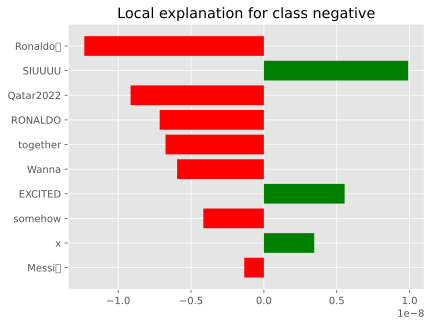

In [102]:
fig = explanation.as_pyplot_figure()

In [103]:
explanation.as_list()[0][1]

-1.23252565889421e-08